In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.feature import StringIndexer
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.functions import *
from pyspark.mllib.stat import Statistics
from pyspark.sql.types import IntegerType, DoubleType, BooleanType, StringType, TimestampType
spark = SparkSession.Builder().appName('DDAM_Project_north').getOrCreate()
sqlCtx = SQLContext(spark)
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.ml.linalg import Vectors
from pyspark.ml import Pipeline

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/15 17:20:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [2]:
df = spark.read.options(inferSchema = True, delimiter = ',', header = True).csv('../../Datasets/North_Incidents.csv')

In [3]:
df.show()

23/12/15 17:20:48 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------+-------+--------+-------------------+-------------------+-----------------+------------------+-------+-------+------------------+--------------------+--------------------+------------+----------+-----+----------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+
|      ID| Source|Severity|         Start_Time|           End_Time|        Start_Lat|         Start_Lng|End_Lat|End_Lng|      Distance(mi)|         Description|              Street|        City|    County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|W

In [4]:
# Remove not interesting variables
to_delete=['ID','Source','Country','Weather_TimeStamp','End_Time','Sunrise_Sunset','Civil_Twilight','Nautical_Twilight','End_Lat','End_Lng','Description','Timezone','Street','Zipcode','Airport_Code']
for col in to_delete:
    df = df.drop(col)


# VARIABLES EXPLORATION

In [5]:
summary = df.describe().toPandas().T
summary

0                     1                     2  \
summary                count                  mean                stddev   
Severity               90767    2.0557030638888585    0.3645781536501668   
Start_Lat              90767     44.41418931931946     1.608292932498082   
Start_Lng              90767    -92.96809021152967        9.062779727945   
Distance(mi)           90767    1.2375613272957153    3.0722175006216146   
City                   90763                  None                  None   
County                 90767                  None                  None   
State                  90767                  None                  None   
Temperature(F)         89651     41.00528716913364    26.549432893991263   
Wind_Chill(F)          89182    35.281929088829585      31.9648219098673   
Humidity(%)            89610     69.13225086485883    18.740909909534913   
Pressure(in)           89709     28.56811713428968     1.231757279734195   
Visibility(mi)         89193    7.9564395187963175    3.3811970515834666   
Wind_Direction         89252                  None                  None   
Wind_Speed(mph)        89254     9.832511708158737     6.498513965424113   
Precipitation(in)      89812  0.004180287712109753  0.028189940271864104   
Weather_Condition      89407                  None                  None   
Astronomical_Twilight  90126                  None                  None   

                                  3                   4  
summary                         min                 max  
Severity                          1                   4  
Start_Lat                 41.732384           48.997334  
Start_Lng                -116.03409          -82.424994  
Distance(mi)                    0.0             118.852  
City                     Abbotsford            Zumbrota  
County                        Adams         Yellowstone  
State                            MI                  WI  
Temperature(F)                -45.0               102.0  
Wind_Chill(F)                 -63.0               102.0  
Humidity(%)                     1.0               100.0  
Pressure(in)                  21.97               29.99  
Visibility(mi)                  0.0                10.0  
Wind_Direction                 CALM                 WSW  
Wind_Speed(mph)                 0.0               130.0  
Precipitation(in)               0.0                 1.4  
Weather_Condition      Blowing Snow  Wintry Mix / Windy  
Astronomical_Twilight           Day               Night

In [6]:
df.dtypes

[('Severity', 'int'),
 ('Start_Time', 'timestamp'),
 ('Start_Lat', 'double'),
 ('Start_Lng', 'double'),
 ('Distance(mi)', 'double'),
 ('City', 'string'),
 ('County', 'string'),
 ('State', 'string'),
 ('Temperature(F)', 'double'),
 ('Wind_Chill(F)', 'double'),
 ('Humidity(%)', 'double'),
 ('Pressure(in)', 'double'),
 ('Visibility(mi)', 'double'),
 ('Wind_Direction', 'string'),
 ('Wind_Speed(mph)', 'double'),
 ('Precipitation(in)', 'double'),
 ('Weather_Condition', 'string'),
 ('Amenity', 'boolean'),
 ('Bump', 'boolean'),
 ('Crossing', 'boolean'),
 ('Give_Way', 'boolean'),
 ('Junction', 'boolean'),
 ('No_Exit', 'boolean'),
 ('Railway', 'boolean'),
 ('Roundabout', 'boolean'),
 ('Station', 'boolean'),
 ('Stop', 'boolean'),
 ('Traffic_Calming', 'boolean'),
 ('Traffic_Signal', 'boolean'),
 ('Turning_Loop', 'boolean'),
 ('Astronomical_Twilight', 'string')]

In [7]:
rows = df.count()
cols = len(df.columns)
print(f'Il Dataset contiene {rows} records e {cols} colonne, il tutto da ripulire poichè presenta valori nulli e presumibilmente altamente correlati')

Il Dataset contiene 90767 records e 31 colonne, il tutto da ripulire poichè presenta valori nulli e presumibilmente altamente correlati


In [8]:
column_types = dict(df.dtypes)

numeric_columns = []
boolean_columns = []
string_columns = []
timestamp_columns = []

for column, data_type in column_types.items():
    if data_type == 'int' or data_type == 'double':
        numeric_columns.append(column)
    elif data_type == 'boolean':
        boolean_columns.append(column)
    elif data_type == 'string':
        string_columns.append(column)
    elif data_type == 'timestamp':
        timestamp_columns.append(column)

# Mostra i risultati
print("Colonnes numeriche:", numeric_columns), print(len(numeric_columns))
print("Colonnes booleane:", boolean_columns), print(len(boolean_columns))
print("Colonnes stringhe:", string_columns), print(len(string_columns))
print("Colonnes timestamp:", timestamp_columns), print(len(timestamp_columns))

print("Numero totale di colonne:", len(df.columns))

Colonnes numeriche: ['Severity', 'Start_Lat', 'Start_Lng', 'Distance(mi)', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)']
11
Colonnes booleane: ['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop']
13
Colonnes stringhe: ['City', 'County', 'State', 'Wind_Direction', 'Weather_Condition', 'Astronomical_Twilight']
6
Colonnes timestamp: ['Start_Time']
1
Numero totale di colonne: 31


In [9]:
unique_weather_conditions = df.select("Weather_Condition").distinct().collect()
# Mostra i valori unici
for row in unique_weather_conditions:
    print(row["Weather_Condition"])

Shallow Fog
Light Snow / Windy
N/A Precipitation
Showers in the Vicinity
Cloudy
Wintry Mix / Windy
Light Freezing Rain
Wintry Mix
Sleet
Blowing Snow
Light Rain with Thunder
Heavy T-Storm
Patches of Fog
Cloudy / Windy
Drizzle
T-Storm
Fog
Partly Cloudy
Fair
Heavy Drizzle
Light Drizzle / Windy
Mostly Cloudy
Heavy Snow / Windy
Smoke
Haze / Windy
Heavy T-Storm / Windy
Heavy Rain
Freezing Rain
Snow / Windy
Fog / Windy
Rain / Windy
Thunder
Light Rain
Mist
Light Snow Shower
Light Rain / Windy
Partly Cloudy / Windy
Rain
Snow
Light Drizzle
Thunder in the Vicinity
Haze
Light Snow
Heavy Snow
Fair / Windy
Mostly Cloudy / Windy
Blowing Snow / Windy
Light Sleet
T-Storm / Windy
Heavy Rain / Windy
Thunder / Windy
Squalls / Windy
Light Freezing Drizzle
Smoke / Windy
Small Hail
Light Snow Shower / Windy
Snow and Sleet
Light Freezing Rain / Windy
Thunder and Hail
Light Rain Shower
Drizzle / Windy
None


In [10]:
#Renaming some variables
for col in numeric_columns:
    new_col = (
        col.replace("(mi)", "_mi")
           .replace("(F)", "_F")
           .replace("(%)", "_perc")
           .replace("(in)", "_in")
           .replace("(mph)", "_mph")
    )
    df = df.withColumnRenamed(col, new_col)

# DATA UNDERSTANDING

In [11]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.functions import date_format, month, hour, col

In [12]:
# Count distinct values columns
for col in df.columns:
    x=df.select(col).distinct().count()
    print('Column',col, 'has',x,'distinct values')
    #print(df.select(col).distinct().collect())

Column Severity has 4 distinct values


Column Start_Time has 65490 distinct values


Column Start_Lat has 45071 distinct values


Column Start_Lng has 45277 distinct values


Column Distance_mi has 7063 distinct values


Column City has 1556 distinct values


Column County has 289 distinct values


Column State has 5 distinct values


Column Temperature_F has 139 distinct values


Column Wind_Chill_F has 162 distinct values


Column Humidity_perc has 98 distinct values


Column Pressure_in has 690 distinct values


Column Visibility_mi has 18 distinct values


Column Wind_Direction has 19 distinct values


Column Wind_Speed_mph has 48 distinct values


Column Precipitation_in has 77 distinct values


Column Weather_Condition has 62 distinct values


Column Amenity has 2 distinct values


Column Bump has 1 distinct values
Column Crossing has 2 distinct values


Column Give_Way has 2 distinct values


Column Junction has 2 distinct values
Column No_Exit has 2 distinct values
Column Railway has 2 distinct values


Column Roundabout has 2 distinct values


Column Station has 2 distinct values
Column Stop has 2 distinct values


Column Traffic_Calming has 2 distinct values


Column Traffic_Signal has 2 distinct values
Column Turning_Loop has 1 distinct values


Column Astronomical_Twilight has 3 distinct values


In [13]:
from pyspark.sql.functions import col,month,hour
# creo la colonna 'month'
df=df.withColumn("month", month("Start_Time"))
# creo la colonna 'day_of_the_week'
df=df.withColumn("day_of_the_week", date_format("Start_Time",'EEEE'))  
# creo la colonna'hour'
df=df.withColumn("hour", hour("Start_Time"))


def season(month_):
    if month_>=3 and month_<=5:
        return 'Spring'
    elif month_>=6 and month_<=8:
        return 'Summer'
    elif month_>=9 and month_<=11:
        return 'Autumn'
    else:
        return 'Winter'

udf_season = udf(season, StringType())
df = df.withColumn("season", udf_season(col("month")))

In [14]:
from pyspark.sql.functions import col
from pyspark.sql.functions import udf
def workingDay_weekend(day_of):
    ins={'Monday','Tuesday','Wednesday','Thursday','Friday'}
    if day_of in ins:
        return 'WorkingDay'
    else:
        return 'Weekend'

udf_workingDay_weekend = udf(workingDay_weekend, StringType())
df = df.withColumn("Working_Weekend", udf_workingDay_weekend(col("day_of_the_week")))

In [15]:
from pyspark.sql.functions import col, when

# The function has to be adapted for each cases: south,nord,est,ovest of US
def update_weather_values(df):
    df_new = df.withColumn(
        "Weather_Condition",
        when(
            col("Weather_Condition").isin("Fair", "Fair / Windy", "Thunder in the Vicinity", "Showers in the Vicinity"),
            "Normal"
        ).when(
            col("Weather_Condition").isin(
                "Fog", "Smoke", "Smoke / Windy", "Haze", "Shallow Fog",
                "Patches of Fog", "Haze / Windy", "Fog / Windy", "Mist",
                "Widespread Dust", "Widespread Dust / Windy", "Blowing Dust / Windy",
                "Blowing Dust", "Drizzle and Fog", "Shallow Fog / Windy"
            ),
            "Foggy"
        ).when(
            col("Weather_Condition").isin(
                "Cloudy", "Cloudy / Windy", "Partly Cloudy", "Mostly Cloudy",
                "Partly Cloudy / Windy", "Mostly Cloudy / Windy"
            ),
            "Cloudy"
        ).when(
            col("Weather_Condition").isin(
                "Wintry Mix", "Sleet", "Light Snow / Windy", "Snow", "Heavy Snow with Thunder",
                "Light Snow", "Heavy Snow", "Light Freezing Rain", "Light Snow Shower", "Light Snow Shower / Windy",
                "Heavy Snow / Windy", "Snow / Windy", "Small Hail", "Light Snow and Sleet / Windy",
                "Blowing Snow / Windy", "Light Sleet / Windy", "Snow and Thunder",
                "Hail", "Wintry Mix / Windy", "Light Snow with Thunder", "Snow and Sleet / Windy", "Heavy Sleet",
                "Thunder and Hail", "Light Sleet", "Light Snow and Sleet", "Snow and Sleet", "Blowing Snow", "Drifting Snow / Windy"
            ),
            "Snow"
        ).when(
            col("Weather_Condition").isin(
                "Rain", "Light Drizzle", "Light Rain with Thunder", "T-Storm", "Tornado",
                "Drizzle", "Heavy Rain", "Thunder", "Light Rain",
                "Light Rain / Windy", "Rain / Windy", "Heavy Rain / Windy",
                "Heavy T-Storm", "Rain Shower", "Squalls", "Heavy T-Storm / Windy",
                "Heavy Drizzle", "Light Rain Shower", "Light Drizzle / Windy",
                "Light Freezing Rain / Windy", "Drizzle / Windy", "Thunder / Windy",
                "T-Storm / Windy", "N/A Precipitation", "Light Freezing Drizzle", "Freezing Rain", "Freezing Rain / Windy", "Squalls / Windy"
            ),
            "Rain"
        ).otherwise(col("Weather_Condition"))
    )

    return df_new

df = update_weather_values(df)
unique_weather_conditions = df.select("Weather_Condition").distinct().collect()
print('\nWeather_Condition distinct values:')
for row in unique_weather_conditions:
    print(row["Weather_Condition"])


Weather_Condition distinct values:
Foggy
Cloudy
Rain
Snow
Normal
None


In [16]:
# le variabili Turning loop e Bump hanno un unico valore
df=df.drop('Turning_Loop', 'Bump')
len(df.columns)

34

In [17]:
#Checking missing values

from pyspark.sql.functions import when, count, isnull
missing = df.select([count(when(isnull(c), c)).alias(c) for c in df.columns])
missing.toPandas().T
missing.show()

+--------+----------+---------+---------+-----------+----+------+-----+-------------+------------+-------------+-----------+-------------+--------------+--------------+----------------+-----------------+-------+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+---------------------+-----+---------------+----+------+---------------+
|Severity|Start_Time|Start_Lat|Start_Lng|Distance_mi|City|County|State|Temperature_F|Wind_Chill_F|Humidity_perc|Pressure_in|Visibility_mi|Wind_Direction|Wind_Speed_mph|Precipitation_in|Weather_Condition|Amenity|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station|Stop|Traffic_Calming|Traffic_Signal|Astronomical_Twilight|month|day_of_the_week|hour|season|Working_Weekend|
+--------+----------+---------+---------+-----------+----+------+-----+-------------+------------+-------------+-----------+-------------+--------------+--------------+----------------+-----------------+-------+--------+--------+-------

## Continuos variables distribution

>>> plotting distribution for Distance_mi


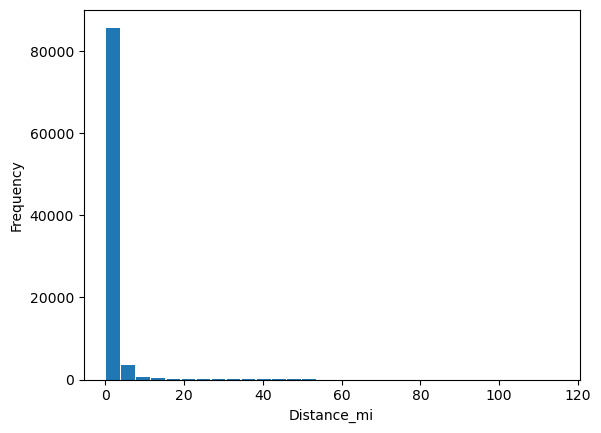

>>> plotting distribution for Temperature_F


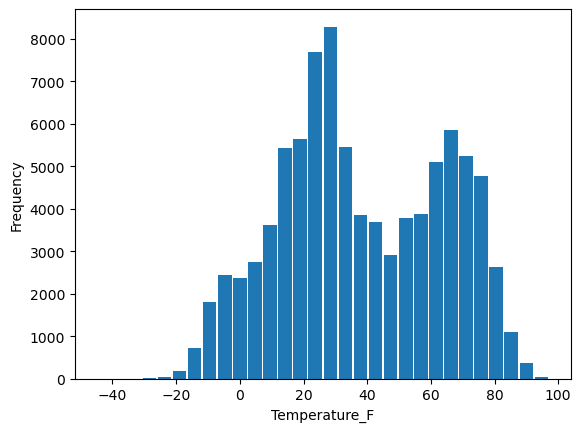

>>> plotting distribution for Wind_Chill_F


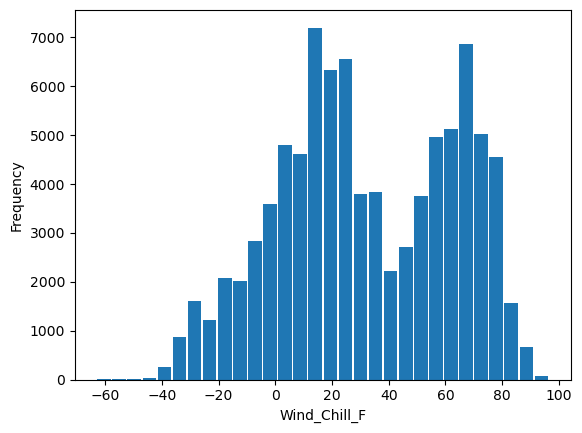

>>> plotting distribution for Humidity_perc


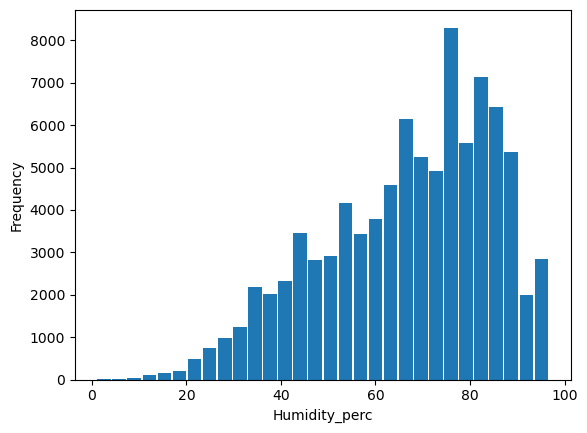

>>> plotting distribution for Pressure_in


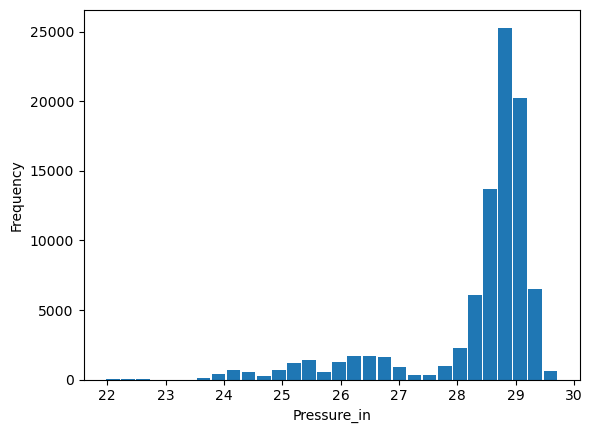

>>> plotting distribution for Visibility_mi


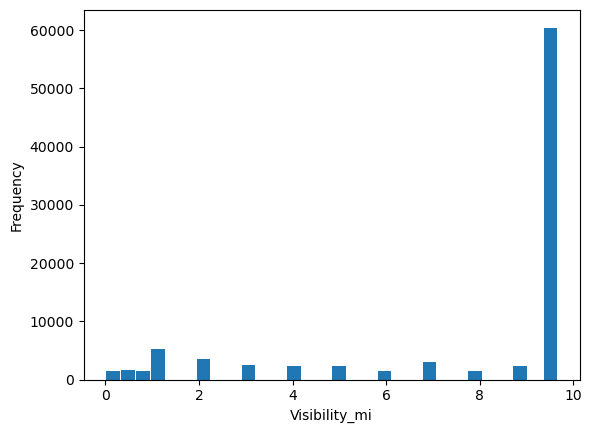

>>> plotting distribution for Wind_Speed_mph


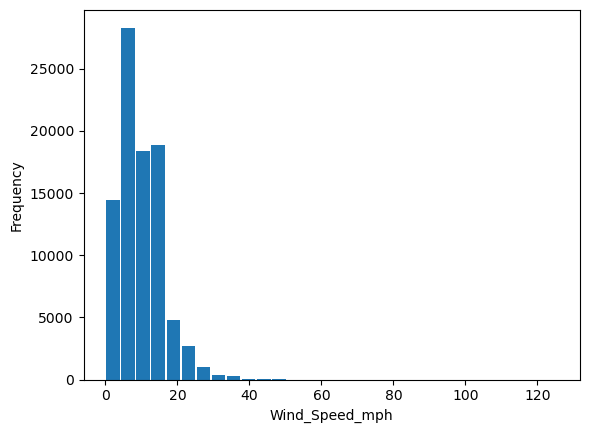

>>> plotting distribution for Precipitation_in


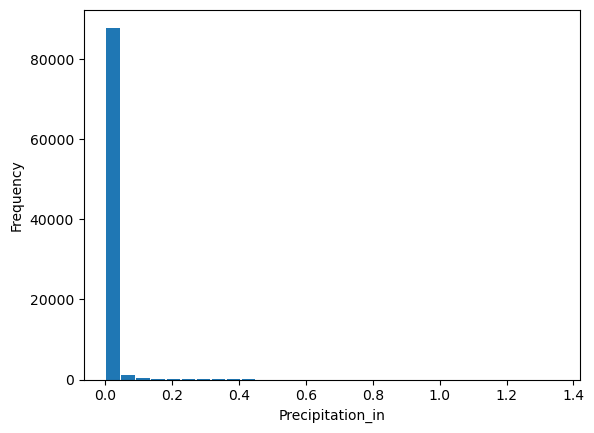

In [18]:
# Analisi distribuzione variabili continue
continuos_features=['Distance_mi', 'Temperature_F', 'Wind_Chill_F', 'Humidity_perc', 'Pressure_in', 'Visibility_mi', 'Wind_Speed_mph', 'Precipitation_in']
df.createOrReplaceTempView("Incidents_Data")

# Itera attraverso le colonne e crea gli istogrammi
for col in continuos_features:
    print(f">>> plotting distribution for {col}")
    query = spark.sql(f'SELECT {col} FROM Incidents_Data') 
    h = query.select(col).rdd.flatMap(lambda x: x).histogram(30) # seleziono colonna specificata dalla query poi converto tutto in un RDD e applico la funzione flatMap per "appiattire" i valori in un singolo elenco. Infine creo istogramma diviso in 50 bin e restituisco una tupla contenente i bin e le frequenze.
    
    # traspone la tupla ottenuta dall'istogramma per ottenere una lista di tuple, ognuna rappresentante un bin e la sua frequenza.
    dfh = pd.DataFrame(
        list(zip(*h)), 
        columns=['bin', 'frequency']
    )
    # estraggo dai dal dataframe pandas per ottenere i bin e le frequenze necessari per il plotting
    bins = dfh['bin']
    counts = dfh['frequency']
    #  classic pandas syntax
    plt.hist(bins, len(bins), weights=counts, rwidth=0.9)
    plt.xlabel(f'{col}', size=10)
    plt.ylabel("Frequency", size=10)
    #plt.grid(True) 
    plt.show()

## Categoric variables frequency

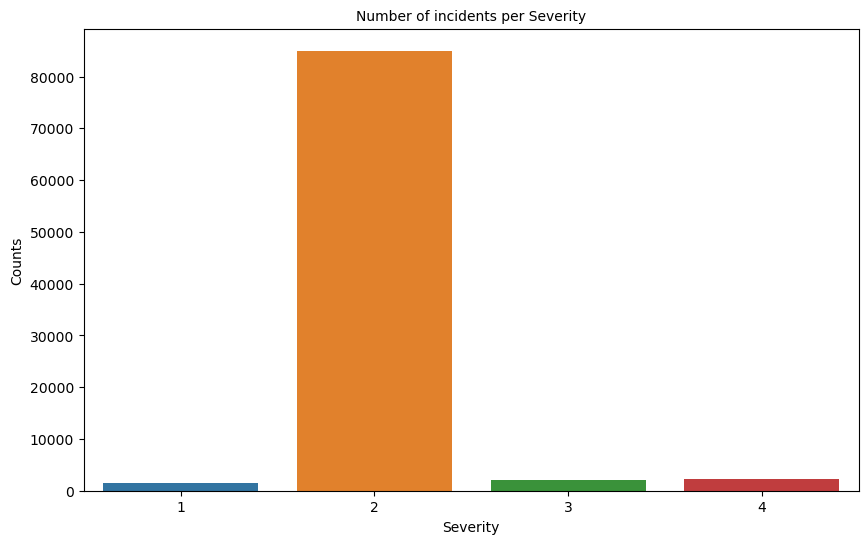

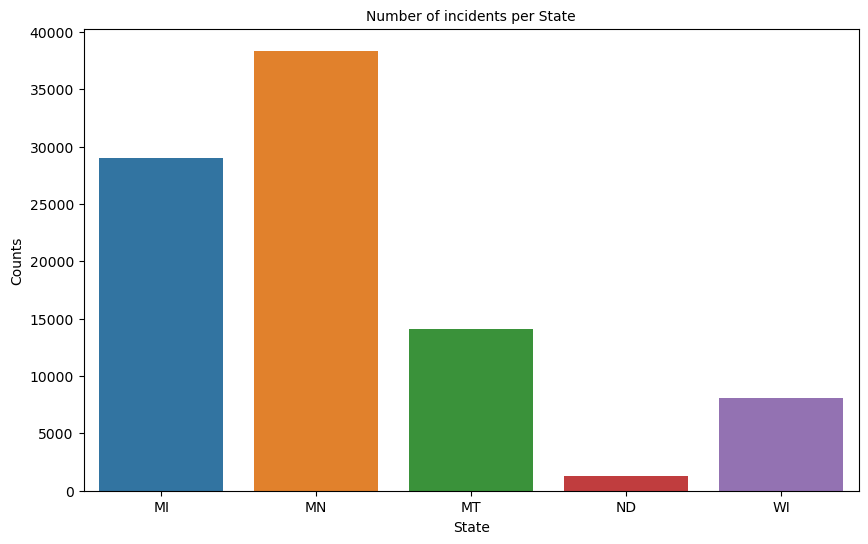

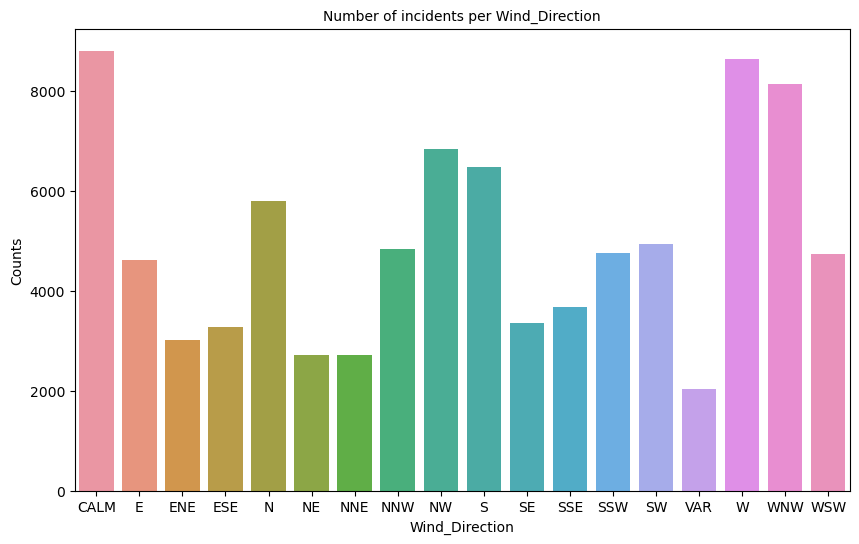

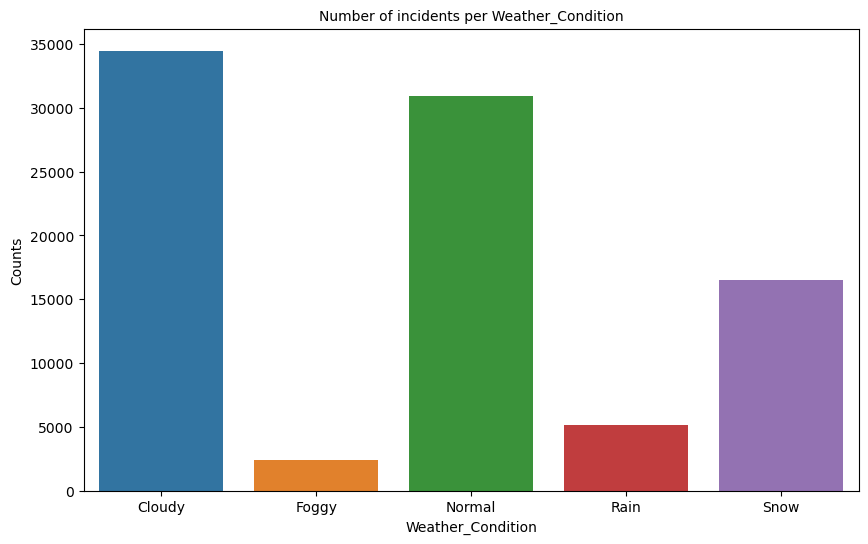

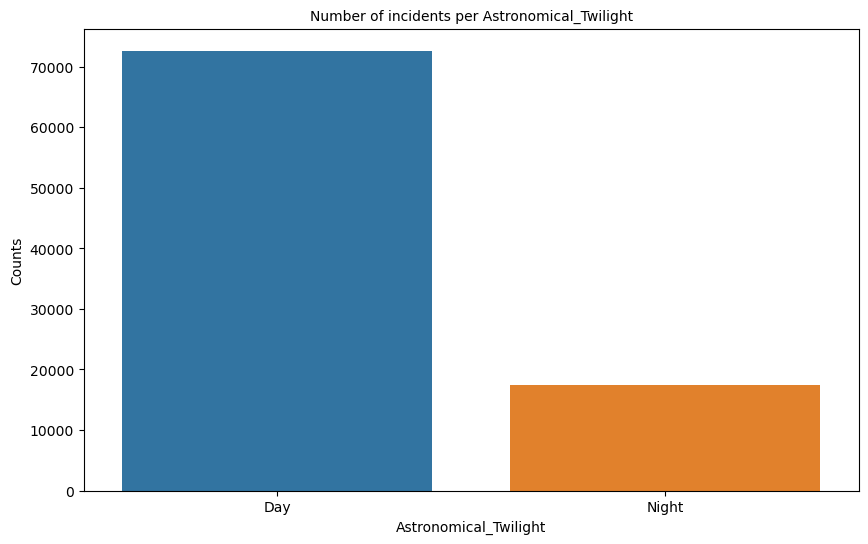

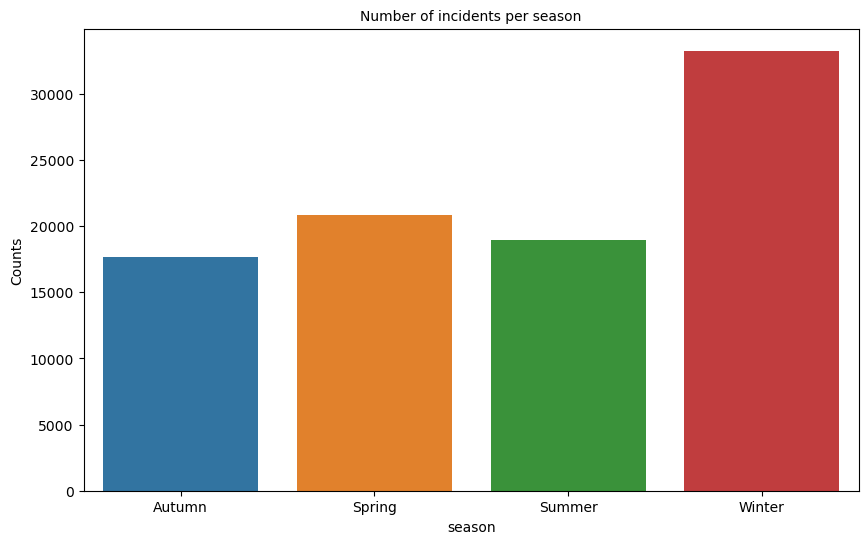

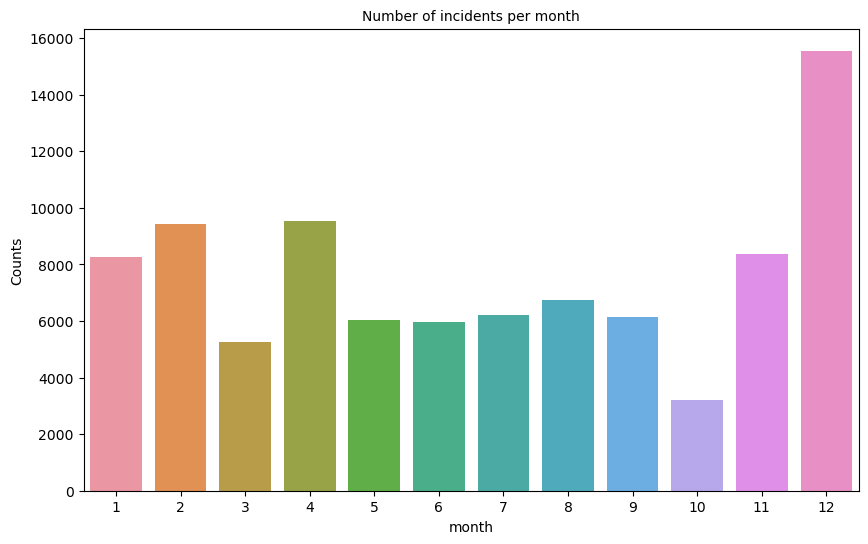

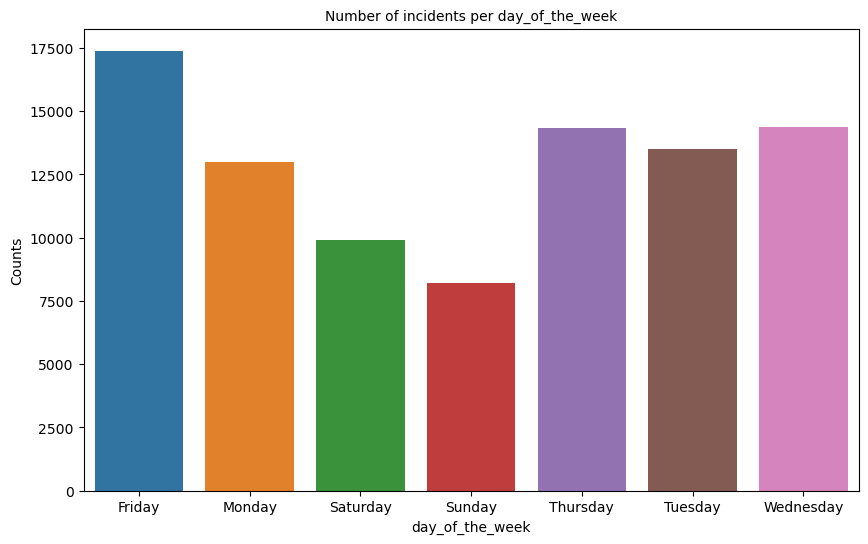

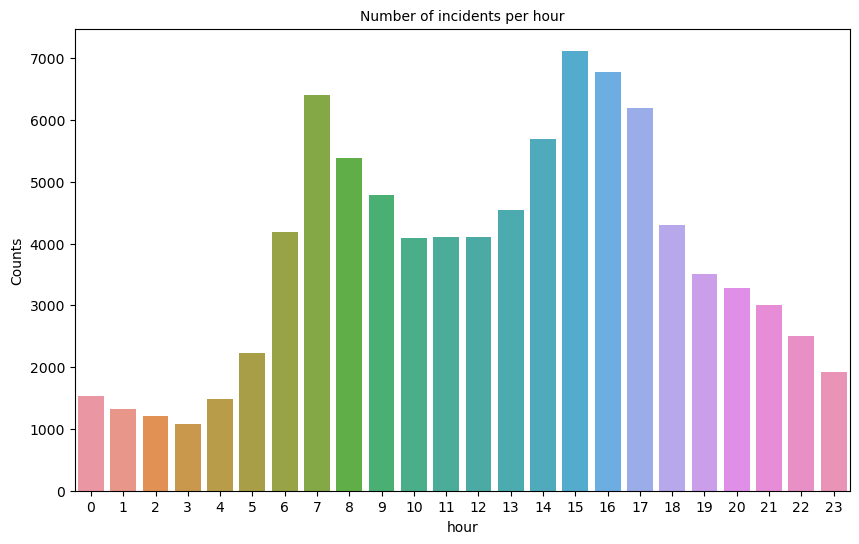

In [19]:
# Analisi barplot variabili categoriche/discrete
discrete_features=['Severity','State', 'Wind_Direction', 'Weather_Condition', 'Astronomical_Twilight','season','month','day_of_the_week','hour']
df.createOrReplaceTempView("Incidents_Data")

for feature in discrete_features:
    feature_freq = spark.sql(f"SELECT {feature}, COUNT(*) as count FROM Incidents_Data GROUP BY {feature}").toPandas()
    feature_freq = feature_freq.sort_values(by=feature)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature, y="count", data=feature_freq)
    plt.xlabel(feature, size=10)
    plt.ylabel("Counts", size=10)
    plt.title(f"Number of incidents per {feature}", size=10)
    plt.show()

## Boolean variables frequency

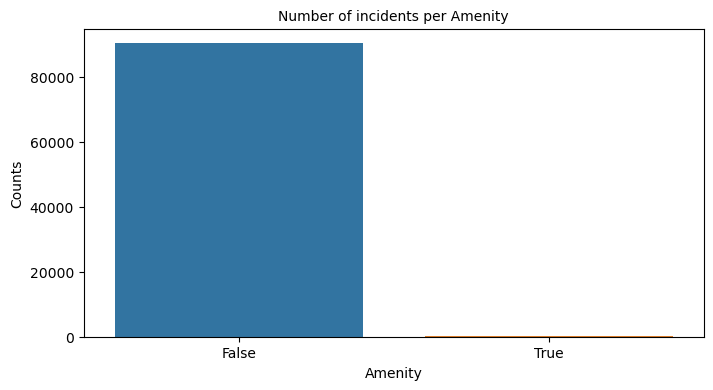

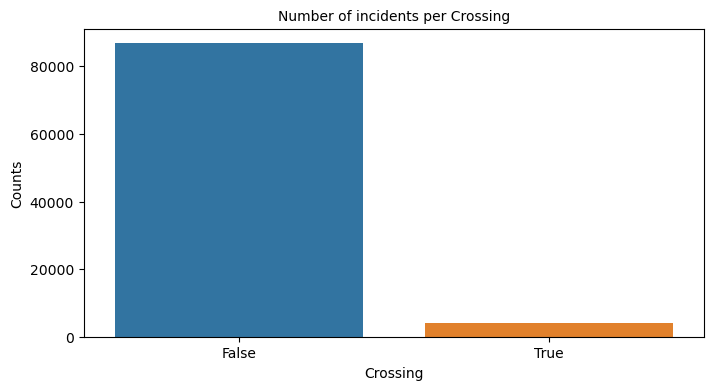

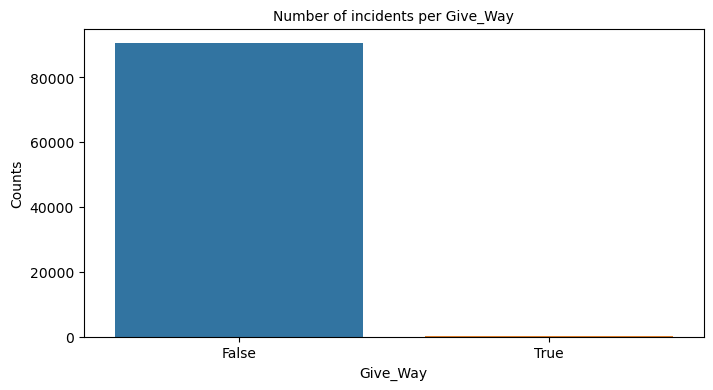

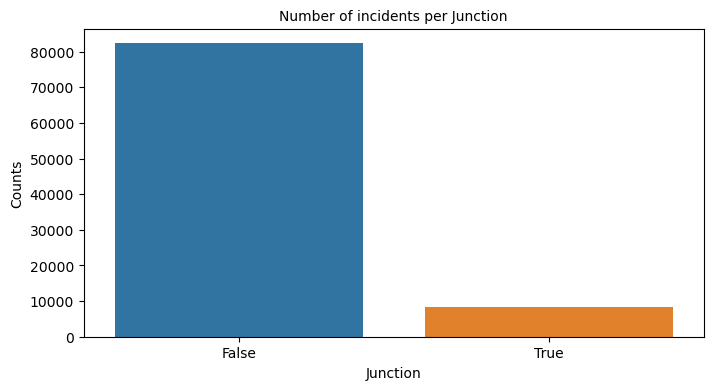

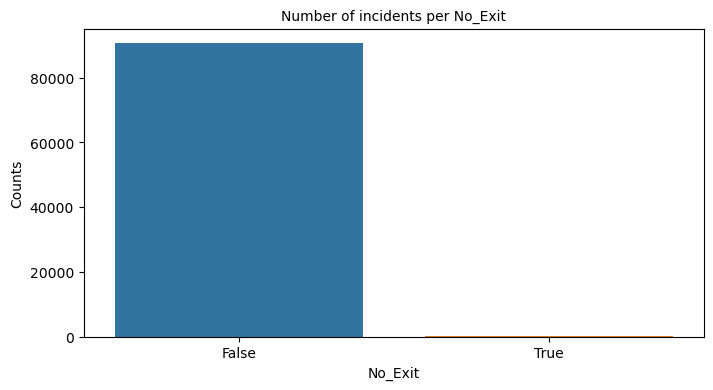

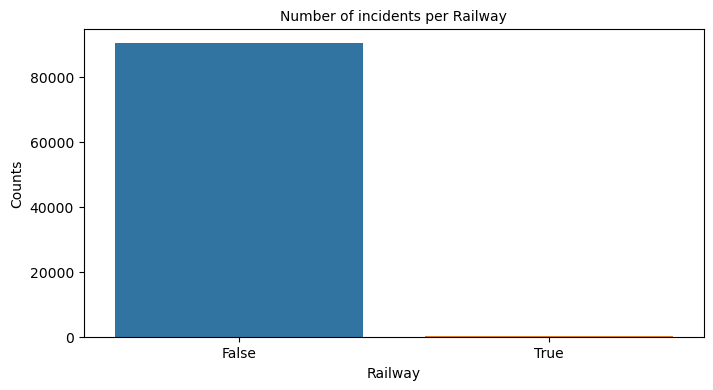

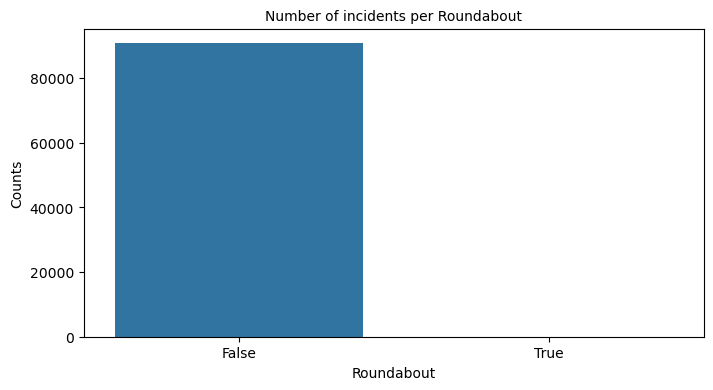

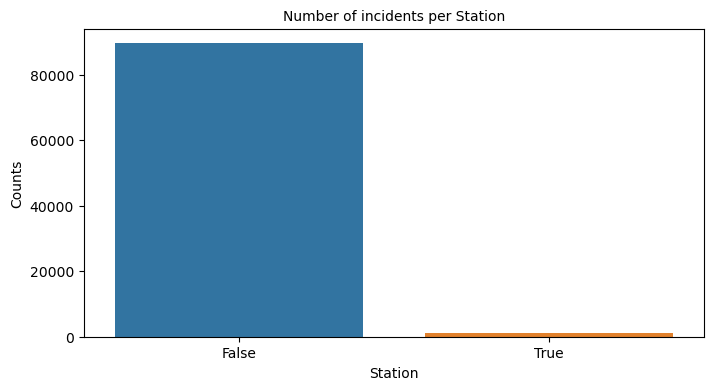

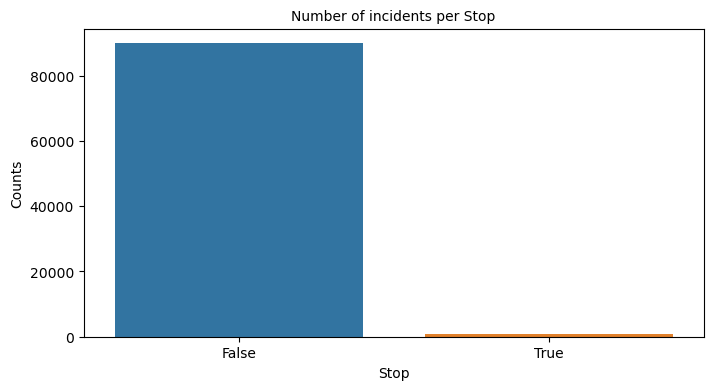

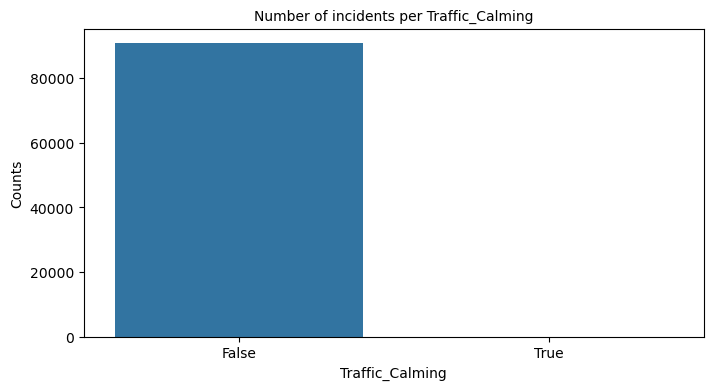

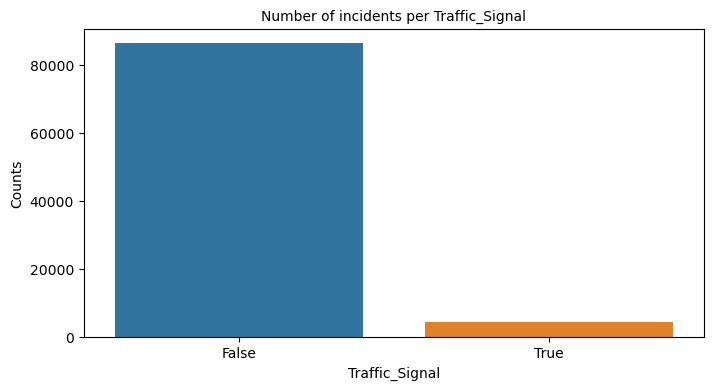

In [20]:
boolean_features=['Amenity', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal']
# Analisi barplot variabili booleane
boolean_features=['Amenity','Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal']
for feature in boolean_features:
    feature_freq = spark.sql(f"SELECT {feature}, COUNT(*) as count FROM Incidents_Data GROUP BY {feature}").toPandas()
    feature_freq = feature_freq.sort_values(by=feature)
    plt.figure(figsize=(8, 4))
    sns.barplot(x=feature, y="count", data=feature_freq)
    plt.xlabel(feature, size=10)
    plt.ylabel("Counts", size=10)
    plt.title(f"Number of incidents per {feature}", size=10)
    plt.show()

In [21]:
# Per le variabili booleane mi creo anche un dataframe di conteggi per visualizzare meglio i valori binari
df.createOrReplaceTempView("Incidents_Data")
boolean_features = ['Amenity', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal']

results = []

for feature in boolean_features:
    counts = df.groupBy(feature).count().collect()

    for count in counts:
        results.append({'Feature': feature, 'Value': count[feature], 'Count': count['count']})

result_df = spark.createDataFrame(results)
result_df.show(result_df.count(), truncate=False)

+-----+---------------+-----+
|Count|Feature        |Value|
+-----+---------------+-----+
|318  |Amenity        |true |
|90449|Amenity        |false|
|3989 |Crossing       |true |
|86778|Crossing       |false|
|264  |Give_Way       |true |
|90503|Give_Way       |false|
|8454 |Junction       |true |
|82313|Junction       |false|
|89   |No_Exit        |true |
|90678|No_Exit        |false|
|297  |Railway        |true |
|90470|Railway        |false|
|90765|Roundabout     |false|
|2    |Roundabout     |true |
|1158 |Station        |true |
|89609|Station        |false|
|912  |Stop           |true |
|89855|Stop           |false|
|12   |Traffic_Calming|true |
|90755|Traffic_Calming|false|
|4427 |Traffic_Signal |true |
|86340|Traffic_Signal |false|
+-----+---------------+-----+



ANALISI AGGIUNTIVE:

1)STATES VS SEVERITY 2)SEASON VS SEVERITY 3)MONTH VS SEVERITY 4)DAY_OF_THE_WEEK VS SEVERITY 5)HOUR VS SEVERITY

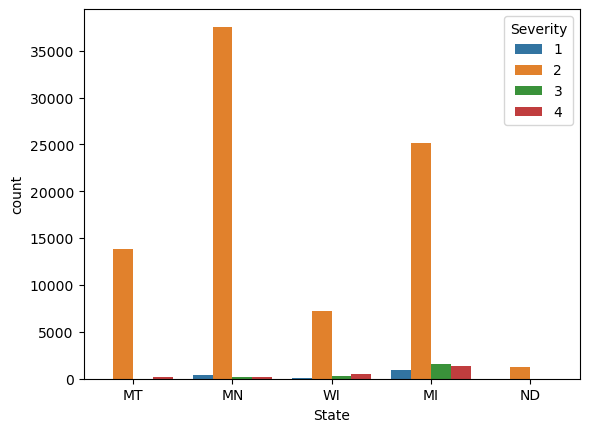

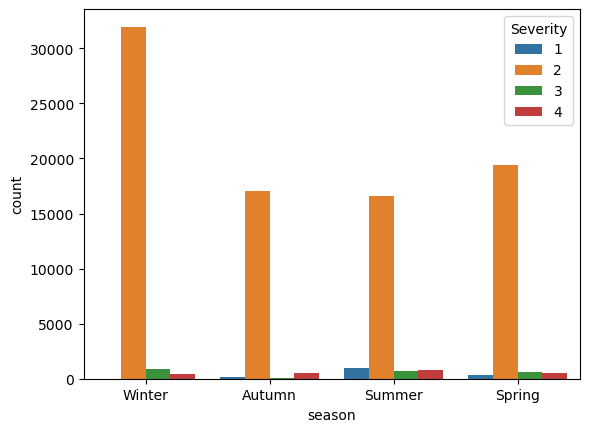

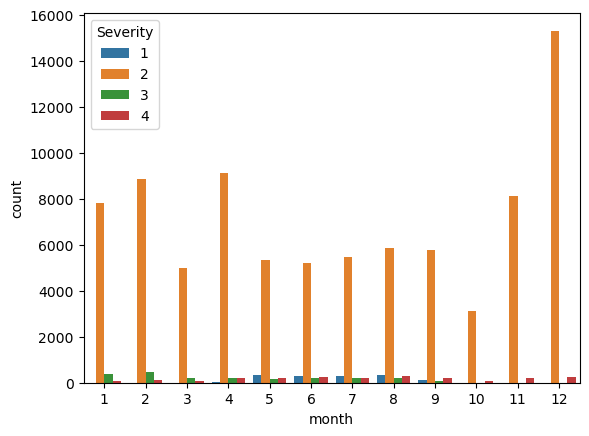

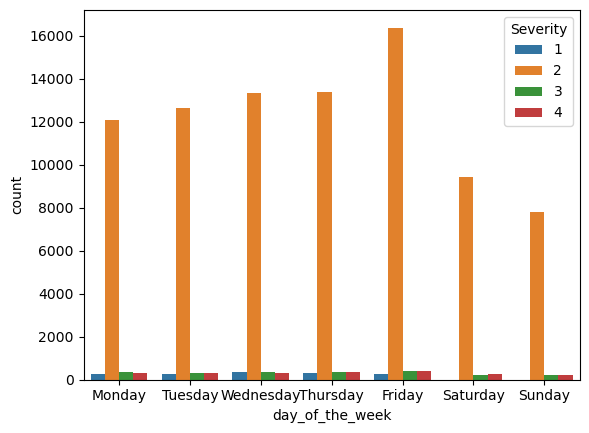

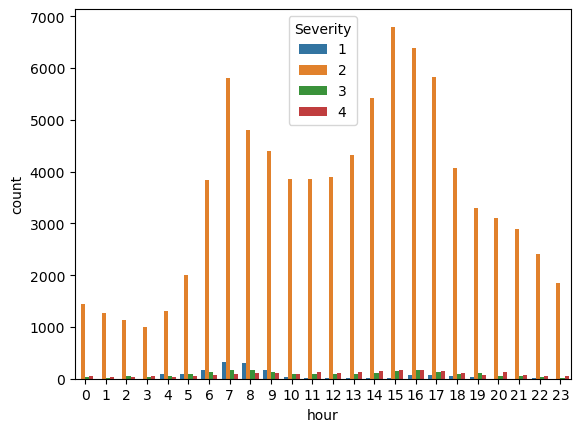

In [22]:
lista = ['State', 'season', 'month', 'day_of_the_week', 'hour']

for col in lista:
    count_ = df.groupBy(col, 'Severity').count().toPandas()
    
    if col == 'day_of_the_week':
        order_of_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        sns.barplot(x=col, y="count", data=count_, hue='Severity', order=order_of_days)
    else:
        sns.barplot(x=col, y="count", data=count_, hue='Severity')
    
    plt.show()
    

<Axes: xlabel='hour', ylabel='count'>

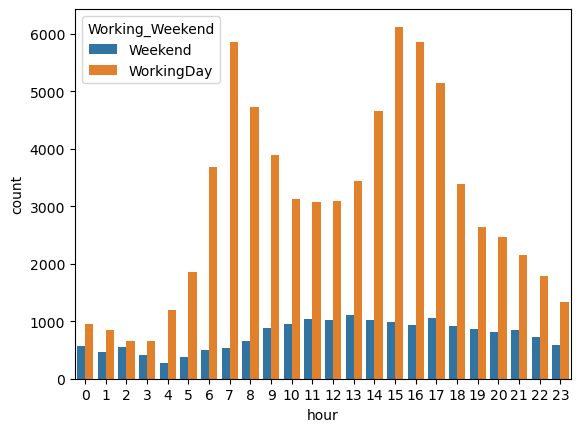

In [23]:
severity_state_count = df.groupBy('hour', 'Working_Weekend').count().toPandas()
sns.barplot(x='hour', y="count", data=severity_state_count, hue='Working_Weekend')

SCATTER PLOT

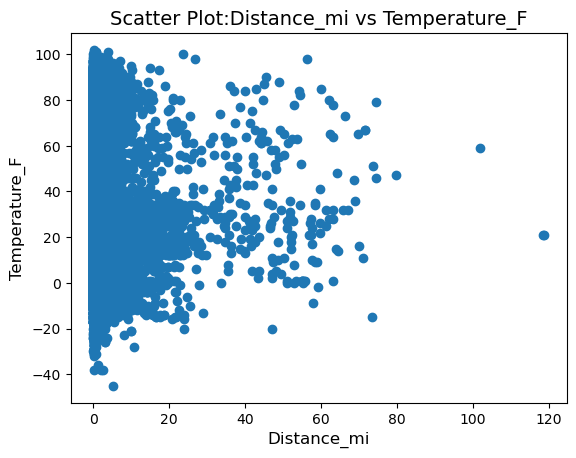

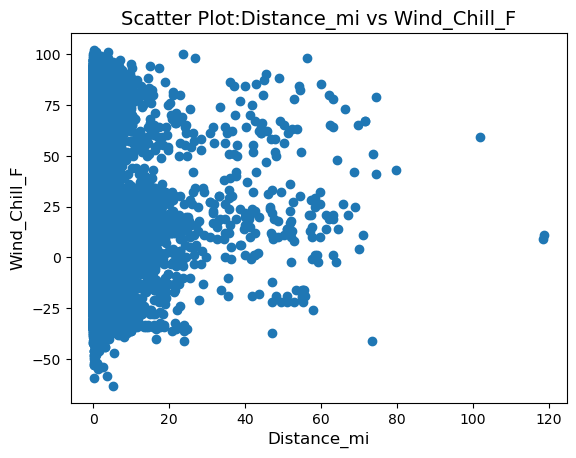

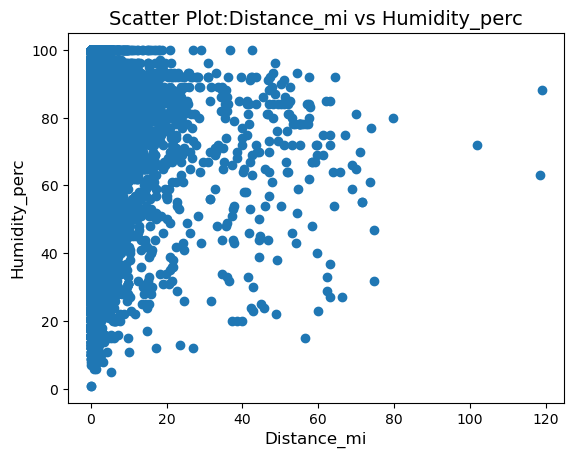

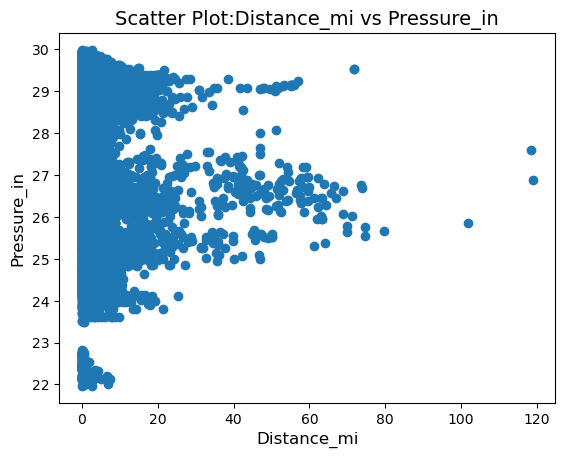

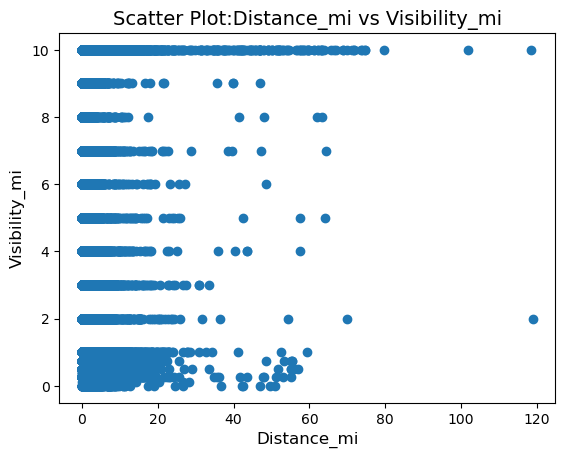

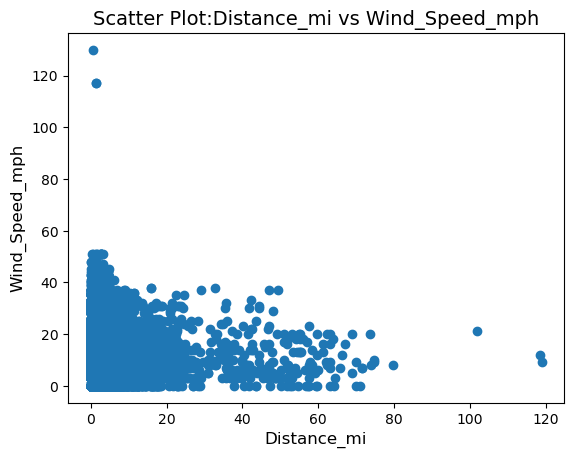

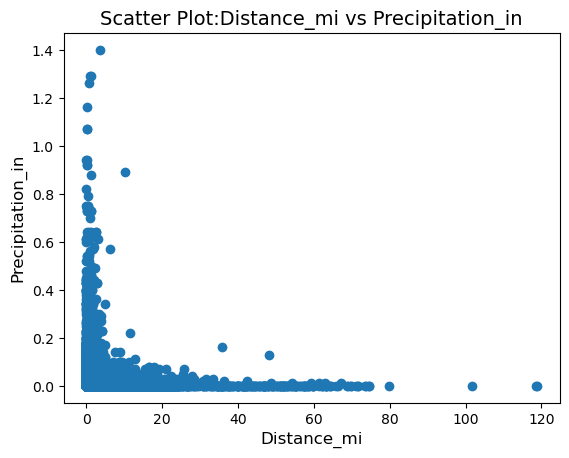

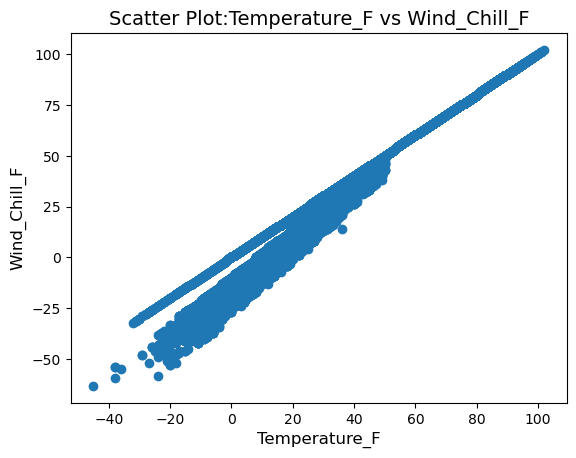

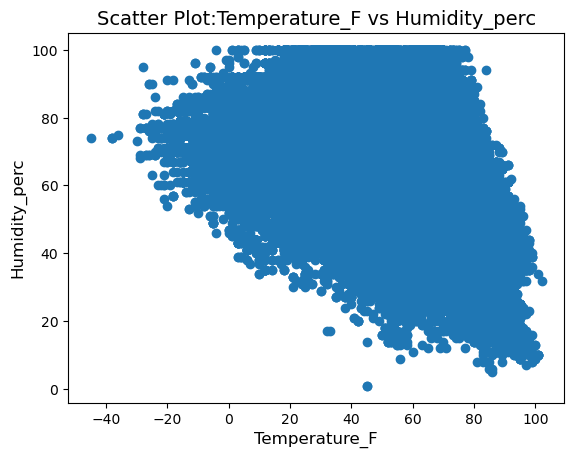

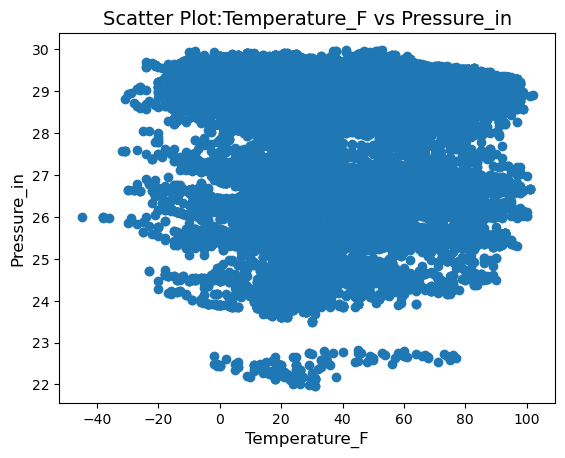

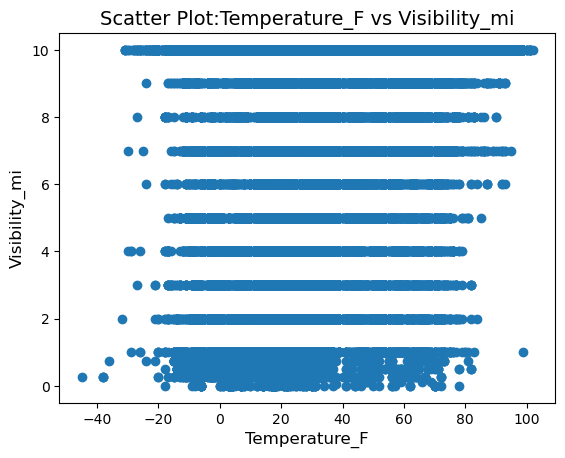

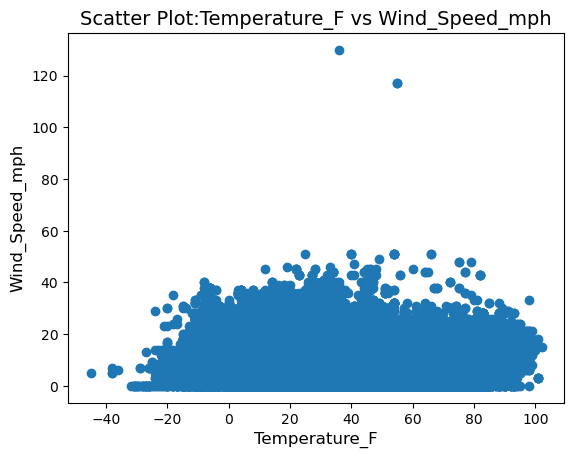

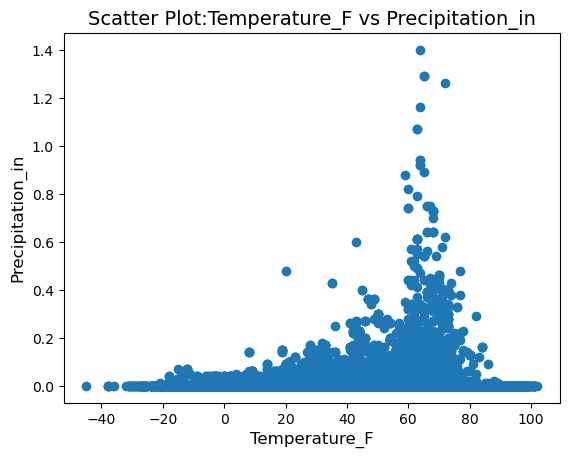

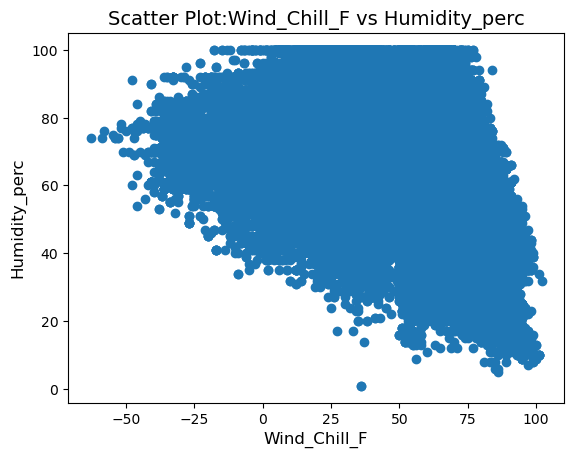

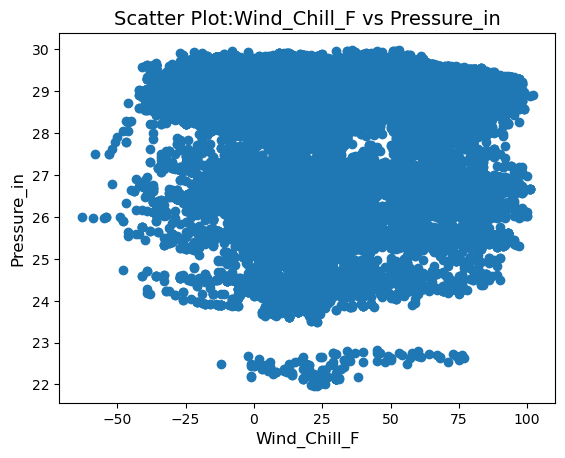

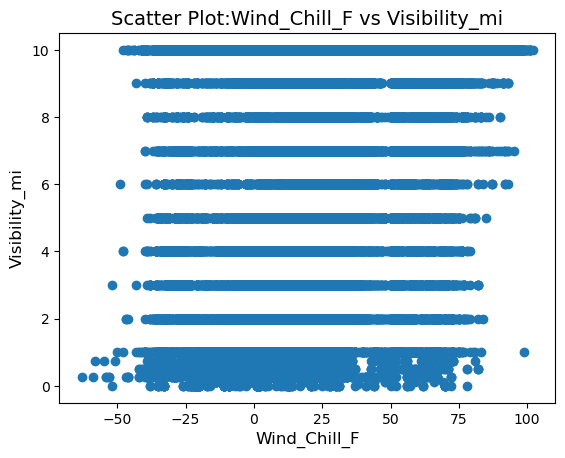

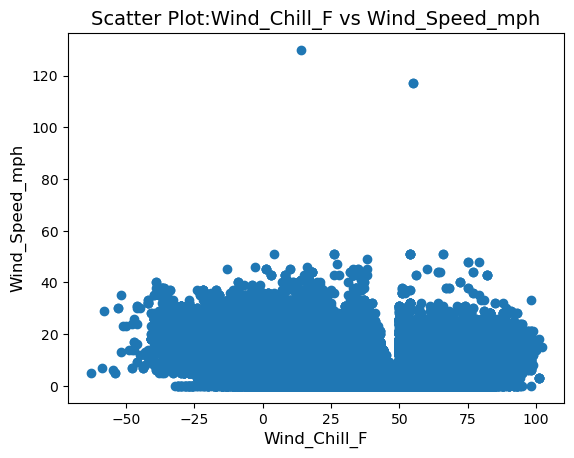

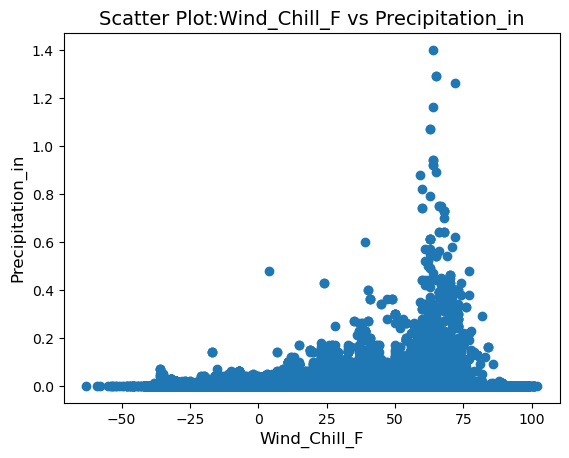

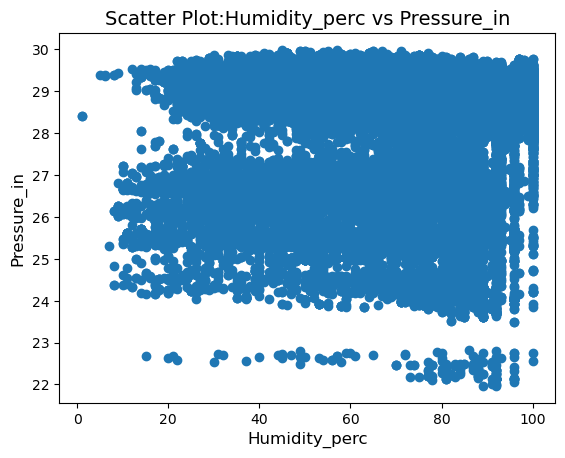

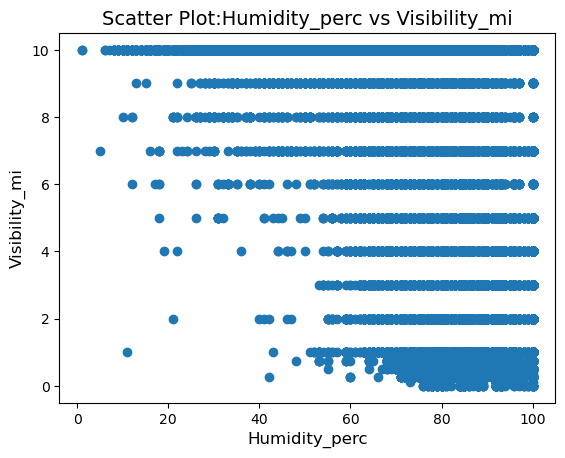

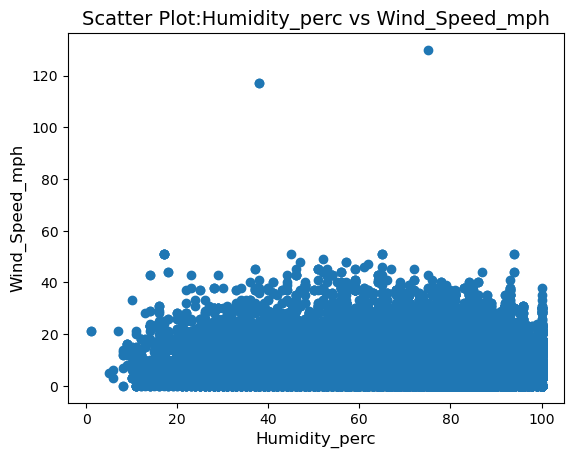

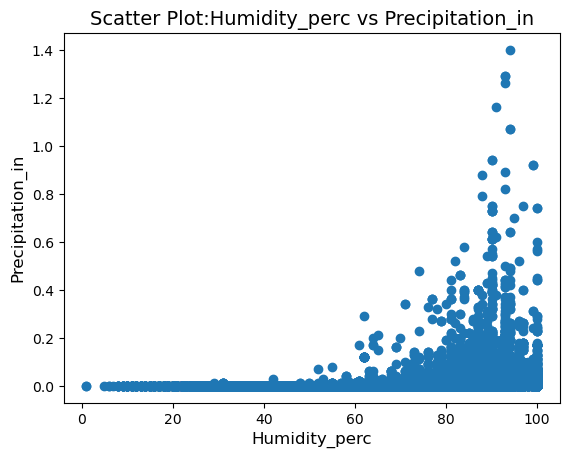

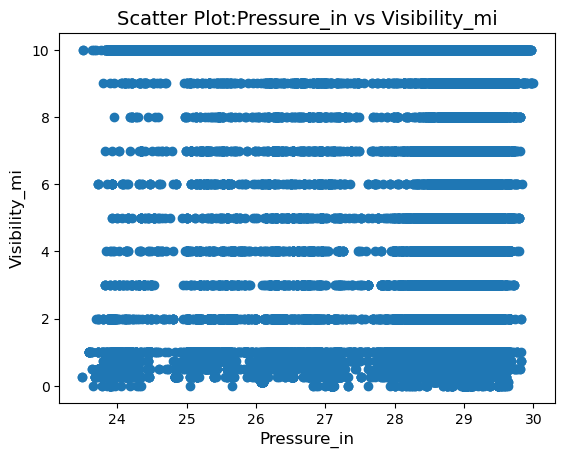

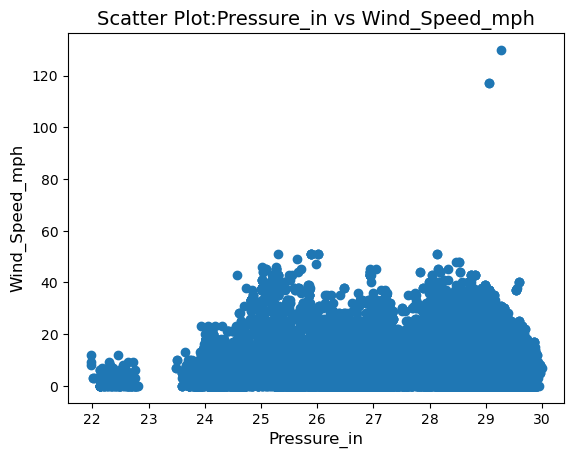

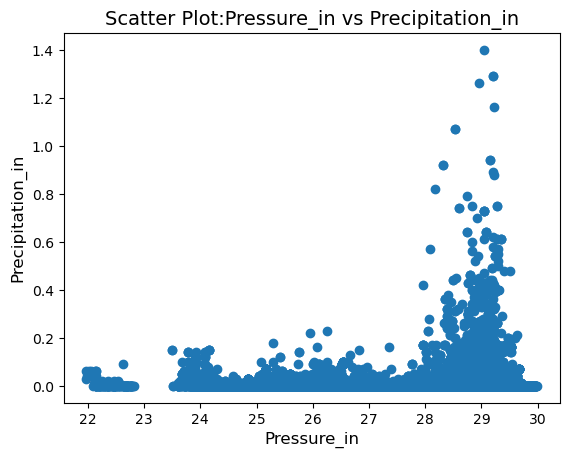

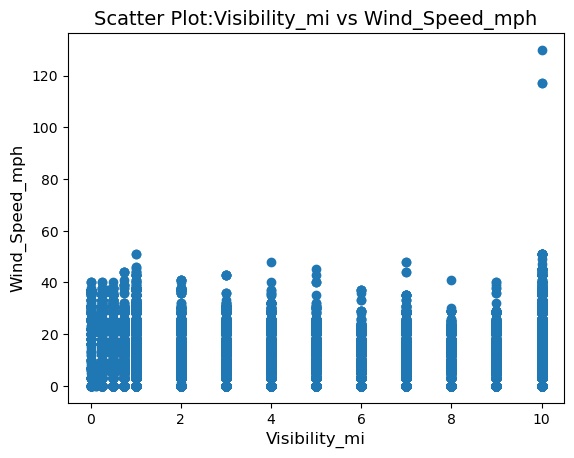

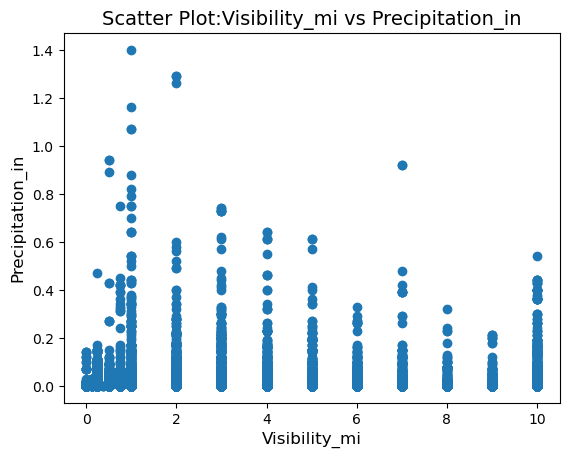

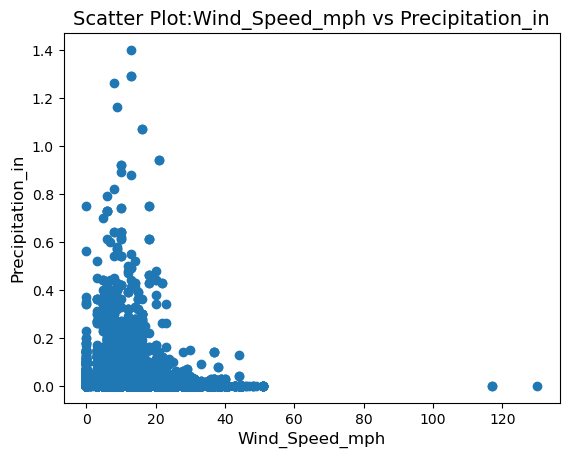

In [24]:
i=0
for el1 in continuos_features:
    for el2 in continuos_features[i+1:]:
        filtered_df = df.filter(df[el1].isNotNull() & df[el2].isNotNull())

        data= filtered_df.select(el1, el2).collect()
        x = [row[el1] for row in data]
        y = [row[el2] for row in data]

        # Crea lo scatterplot utilizzando matplotlib
        plt.scatter(x, y)
        plt.xlabel(el1, size=12)
        plt.ylabel(el2, size=12)
        plt.title("Scatter Plot:"+ el1 +" vs "+el2, size=14)
        plt.show()
    i+=1

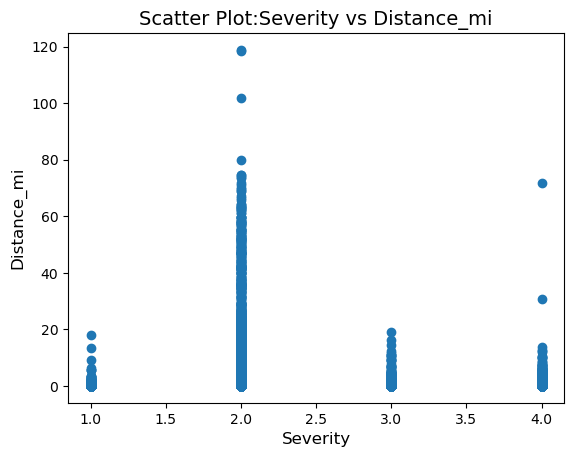

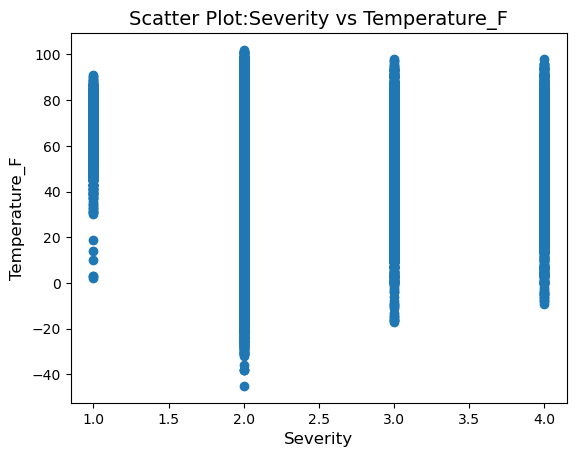

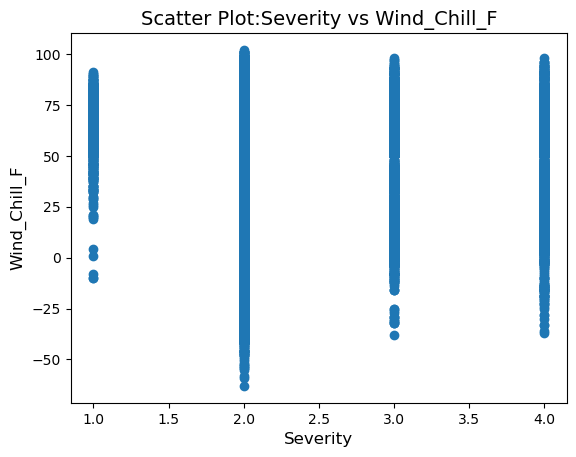

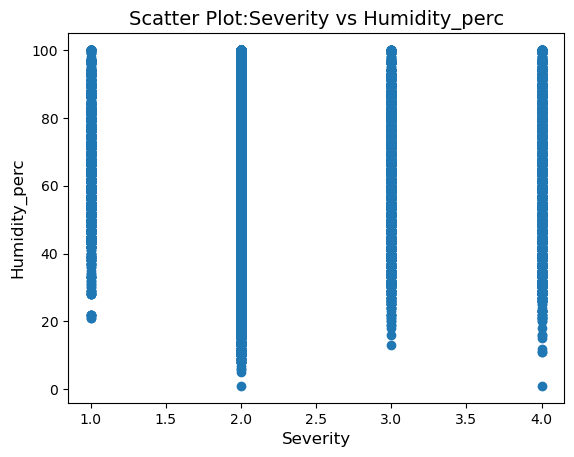

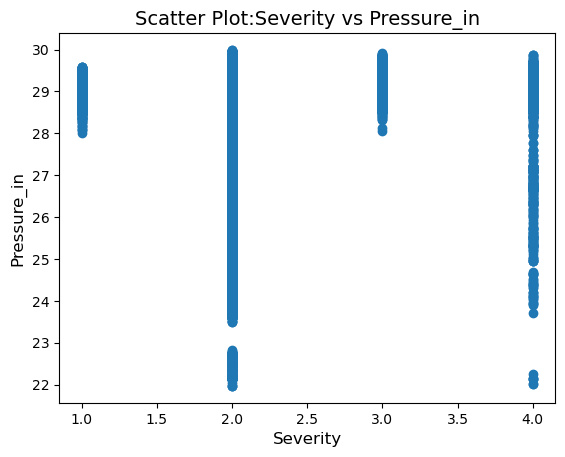

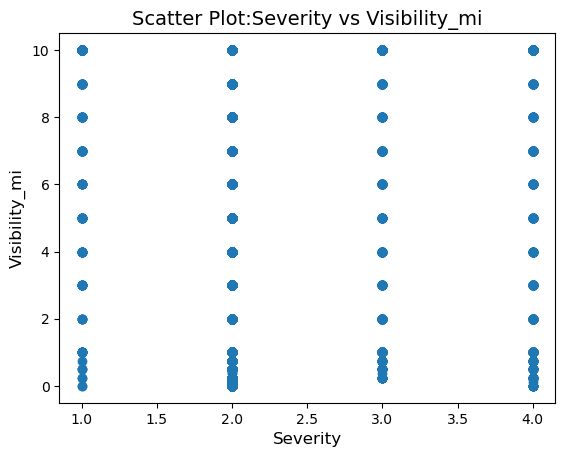

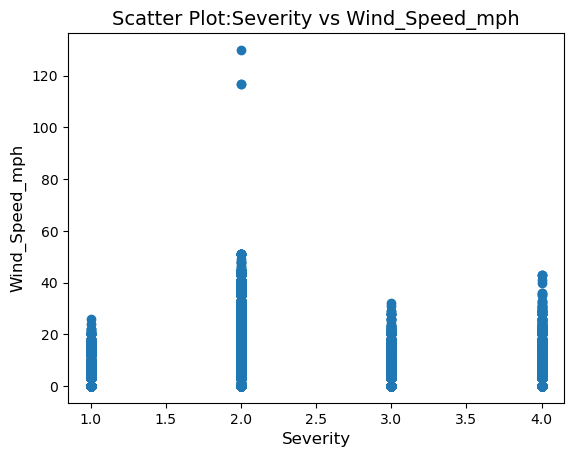

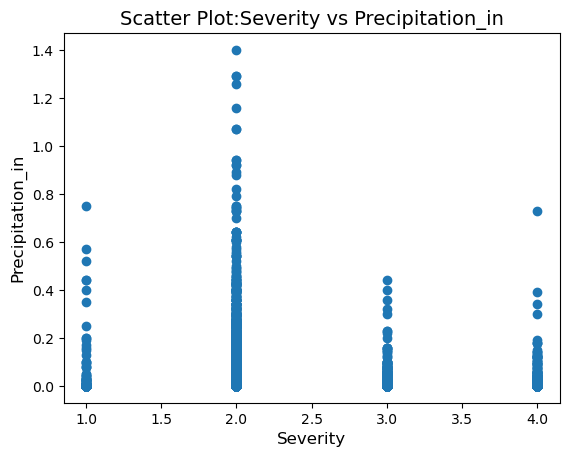

In [25]:
#SCATTER PLOT PER SEVERITY
el1='Severity'
for el2 in continuos_features:
    filtered_df = df.filter(df[el1].isNotNull() & df[el2].isNotNull())

    data= filtered_df.select(el1, el2).collect()
    x = [row[el1] for row in data]
    y = [row[el2] for row in data]

    # Crea lo scatterplot utilizzando matplotlib
    plt.scatter(x, y)
    plt.xlabel(el1, size=12)
    plt.ylabel(el2, size=12)
    plt.title("Scatter Plot:"+ el1 +" vs "+el2, size=14)
    plt.show()

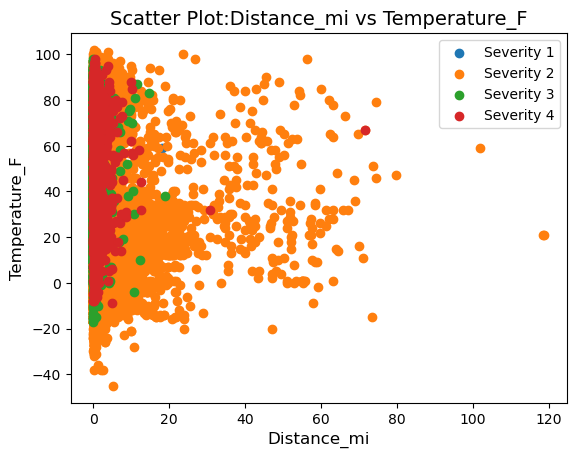

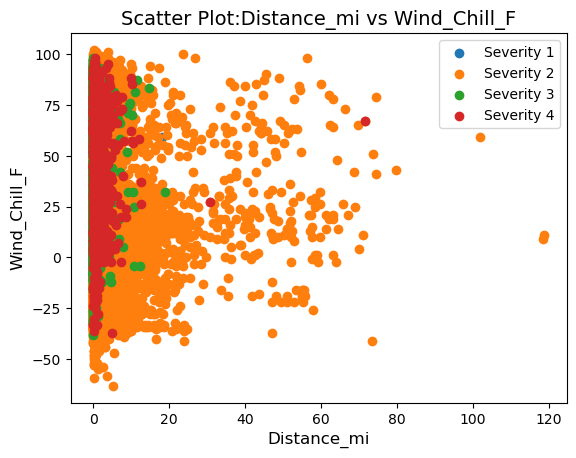

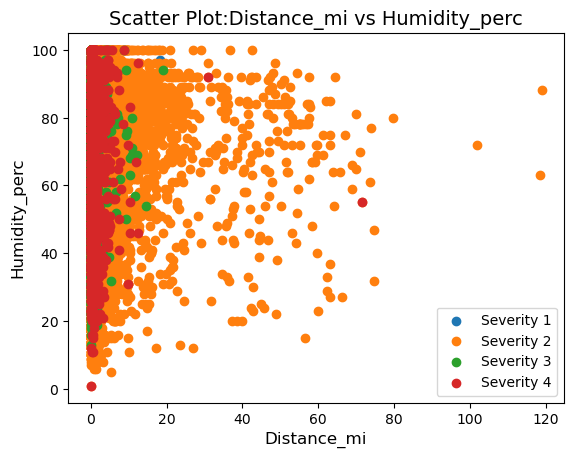

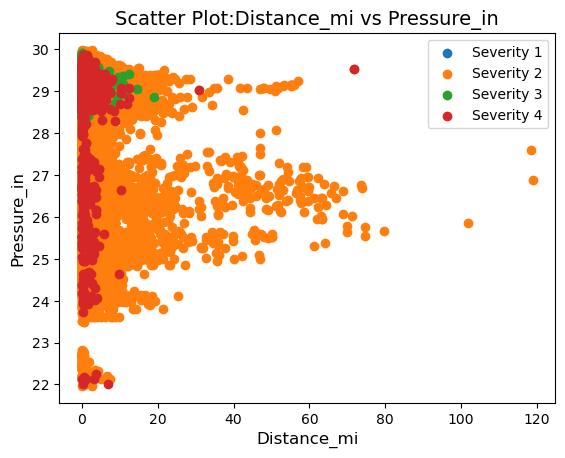

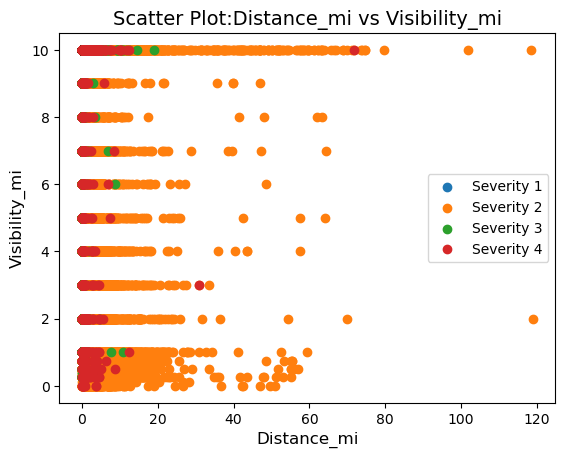

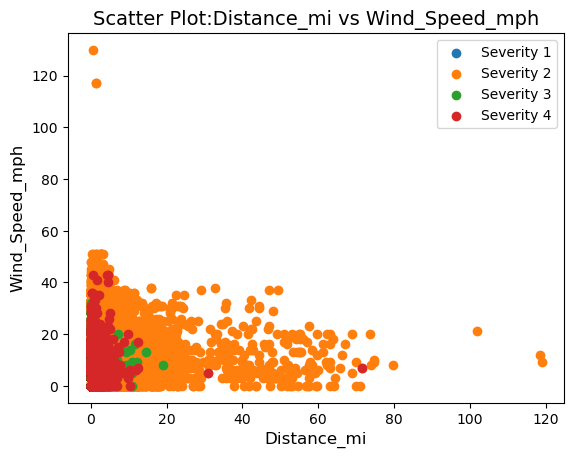

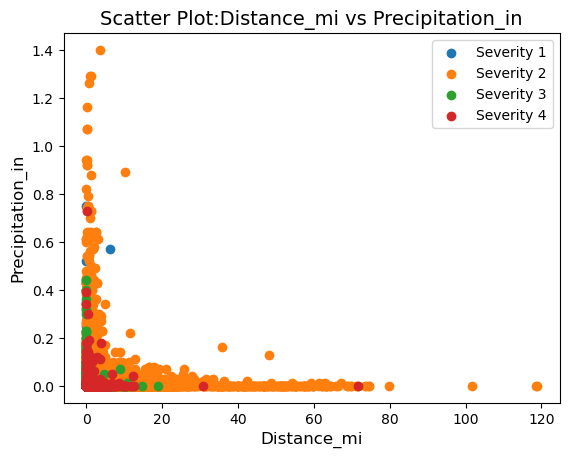

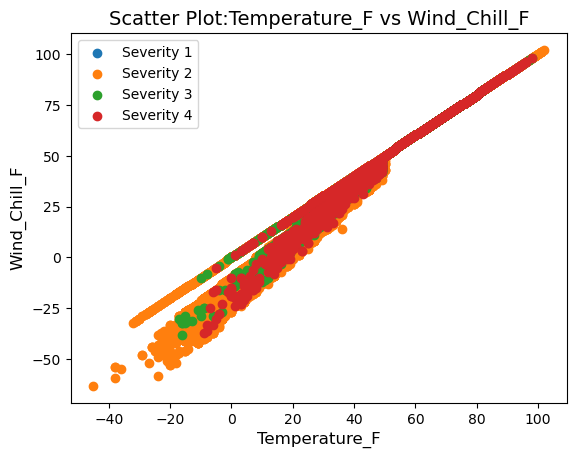

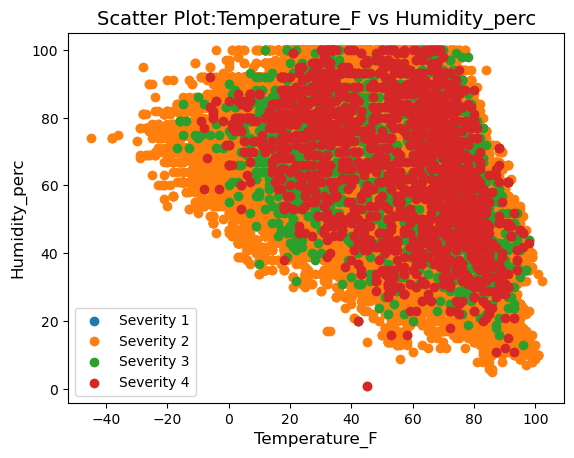

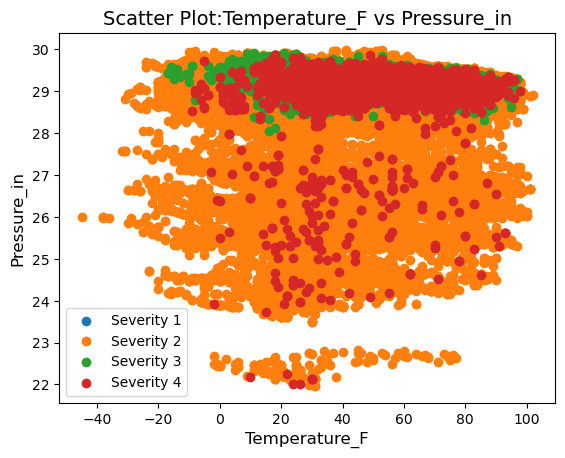

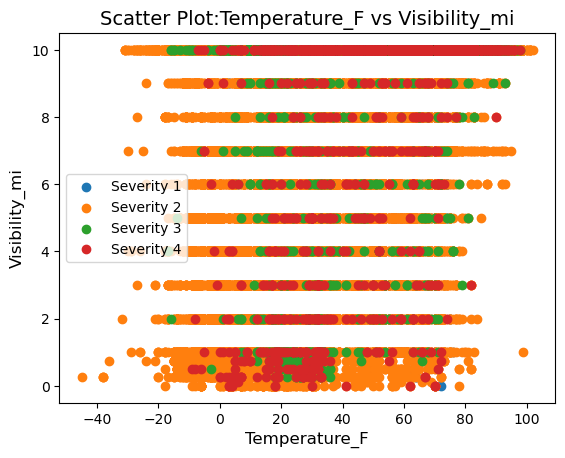

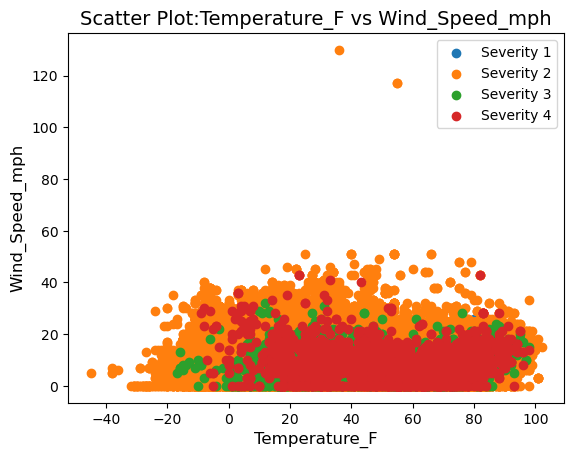

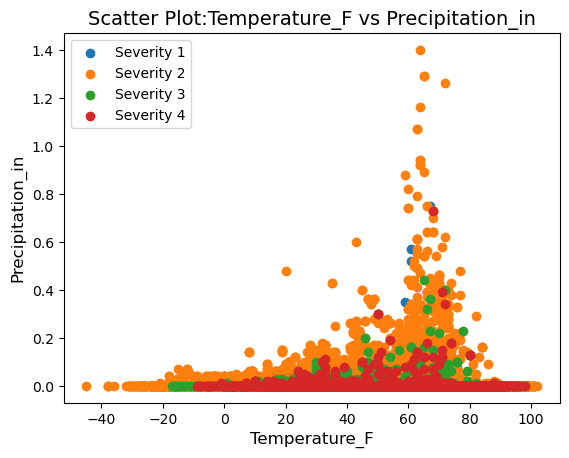

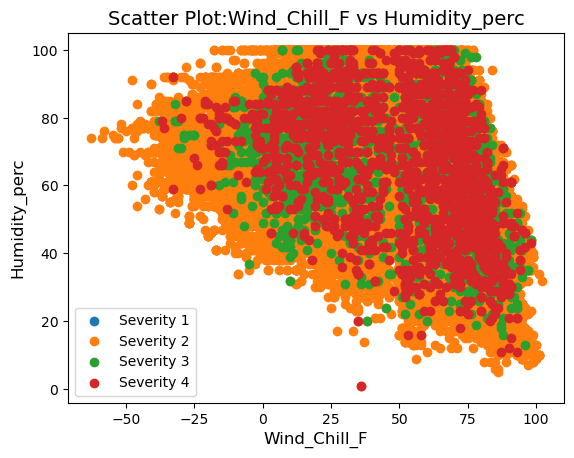

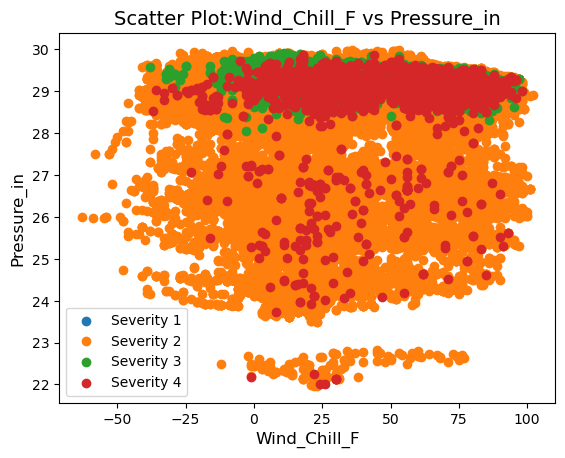

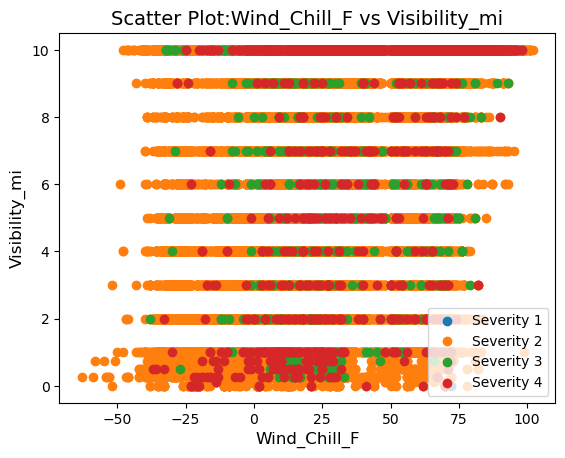

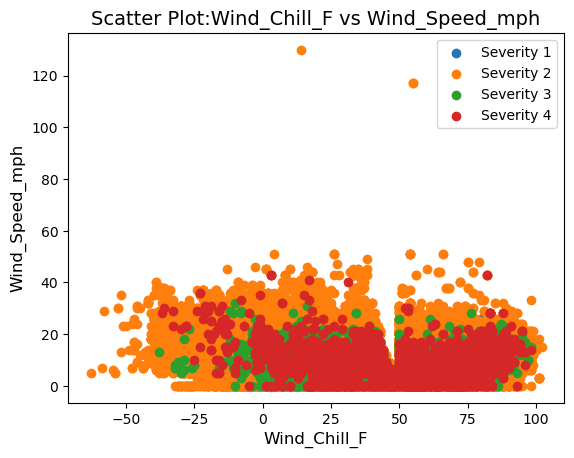

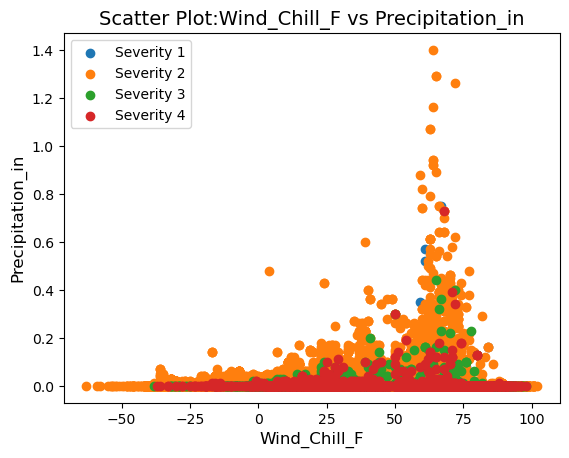

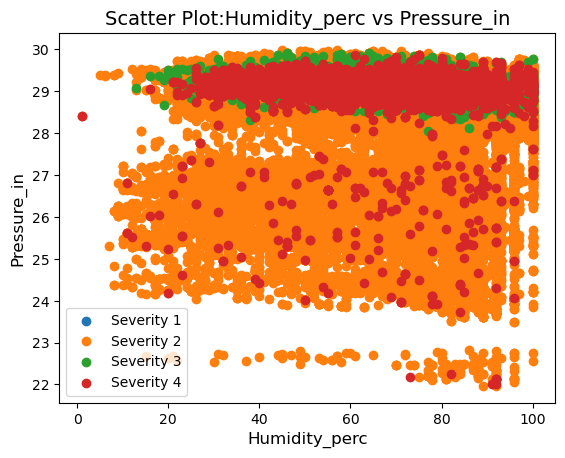

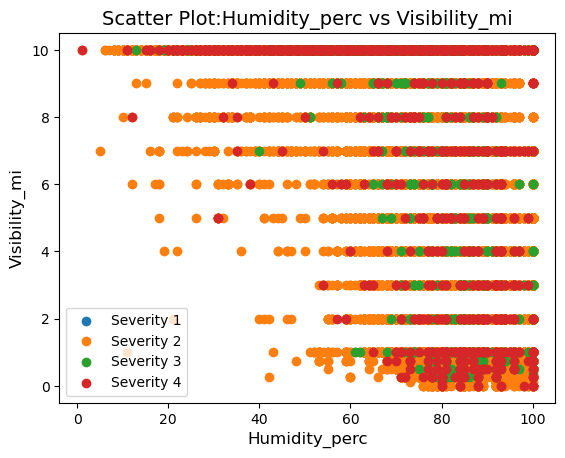

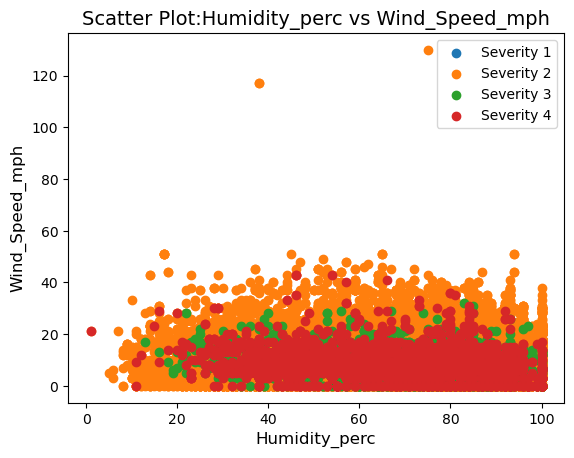

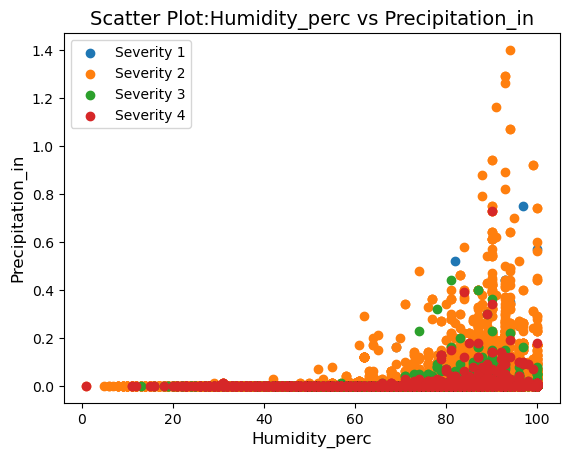

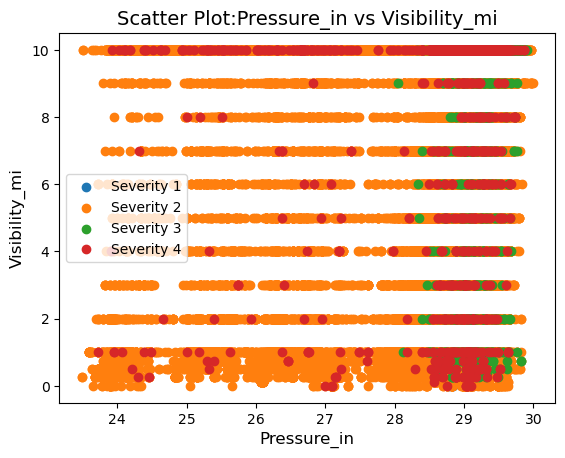

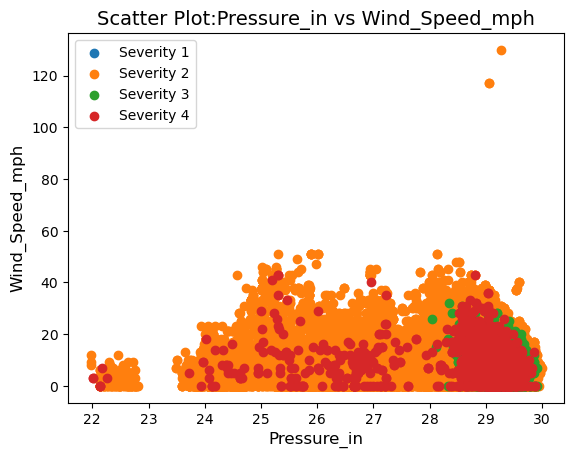

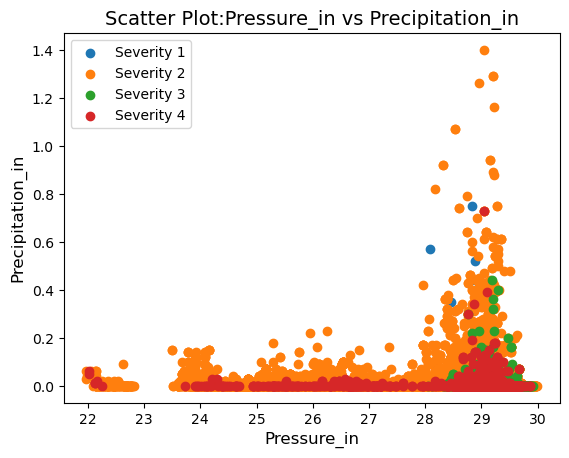

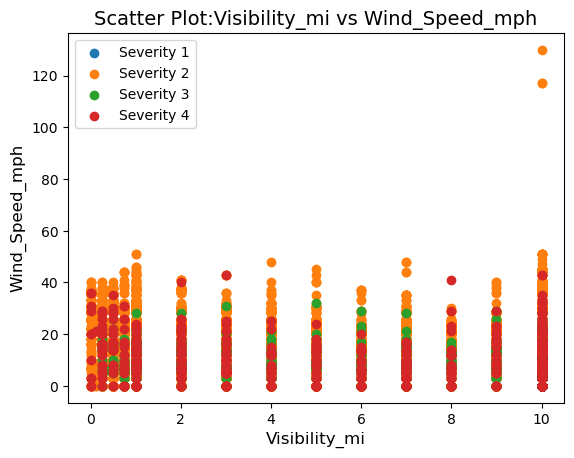

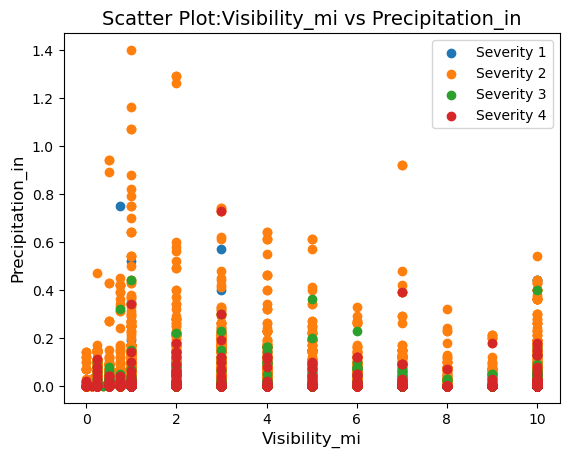

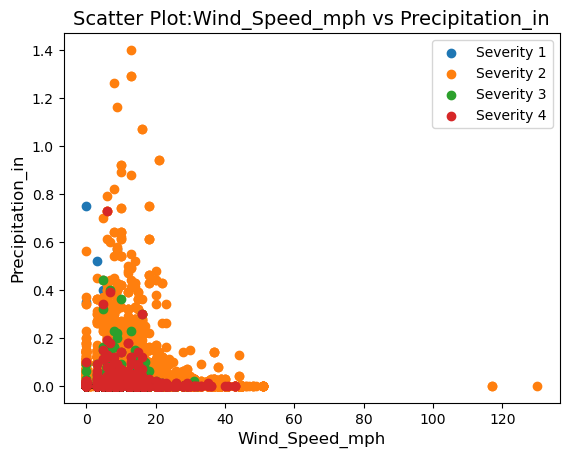

In [26]:
#label severity
i=0
unique_severity =[1,2,3,4]
for el1 in continuos_features:
    for el2 in continuos_features[i+1:]:
        for severity_val in unique_severity:
            data = df.filter(df['Severity'] == severity_val).select(el1, el2).dropna().collect()
            x = [row[el1] for row in data]
            y = [row[el2] for row in data]

            plt.scatter(x, y, label=f'Severity {severity_val}')

        plt.xlabel(el1, size=12)
        plt.ylabel(el2, size=12)
        plt.title('Scatter Plot:'+el1+ ' vs '+ el2, size=14)
        plt.legend()
        plt.show()
    i+=1

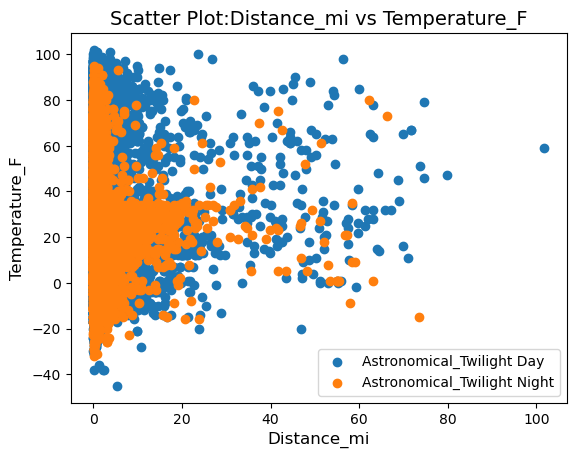

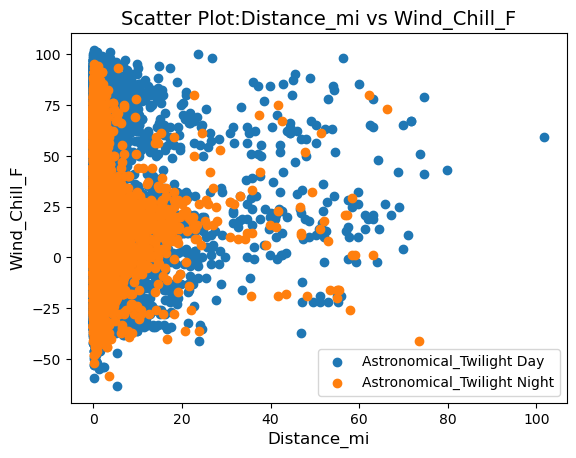

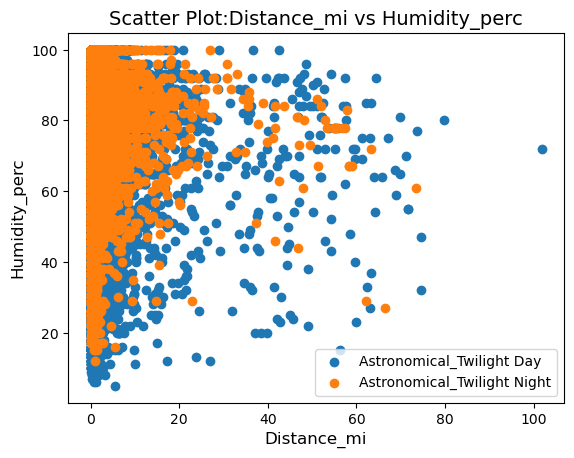

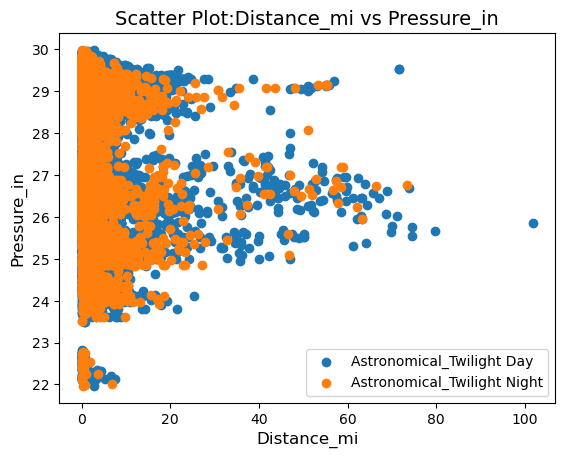

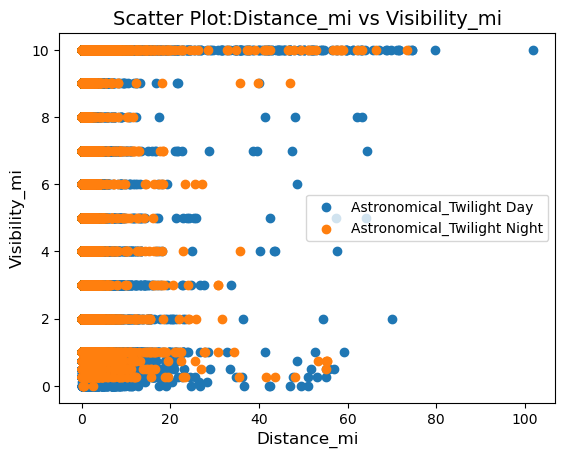

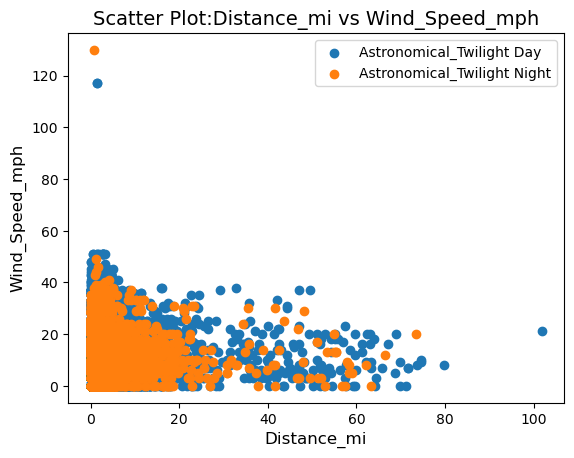

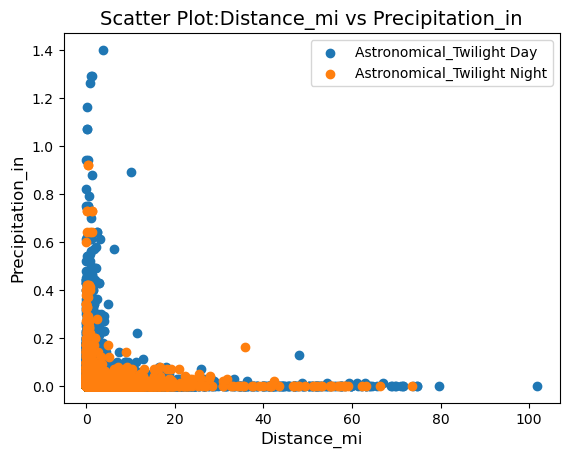

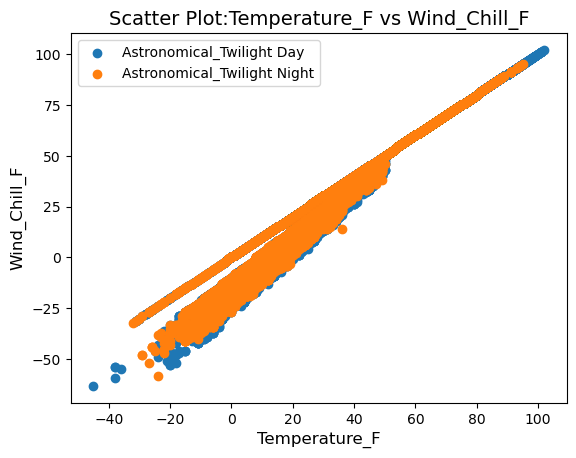

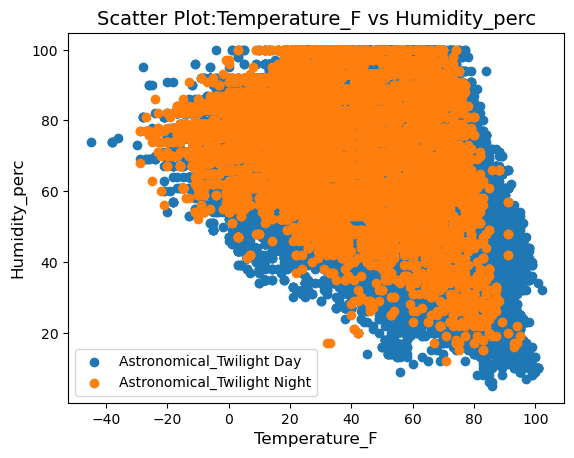

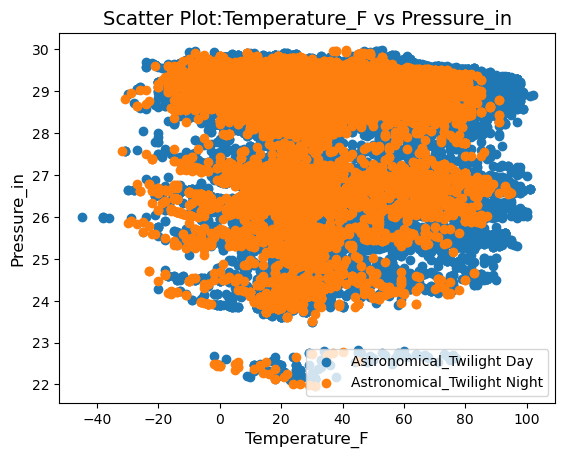

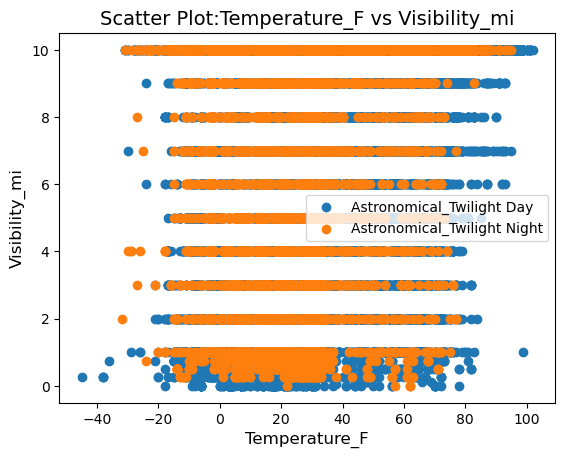

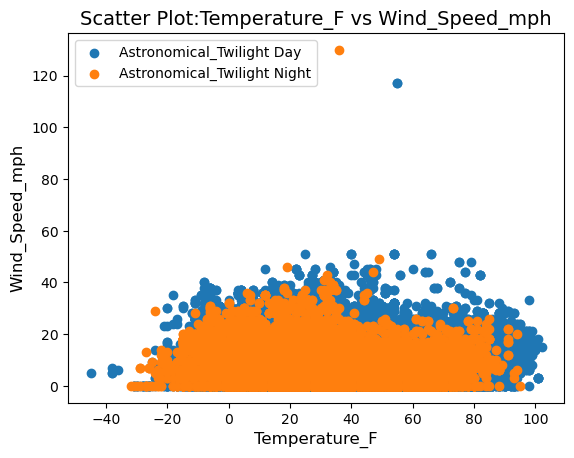

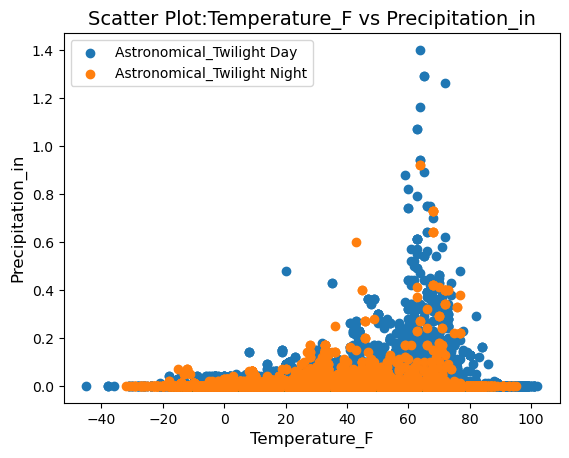

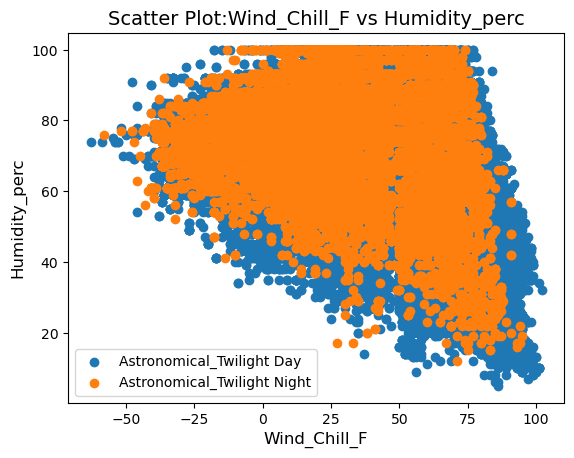

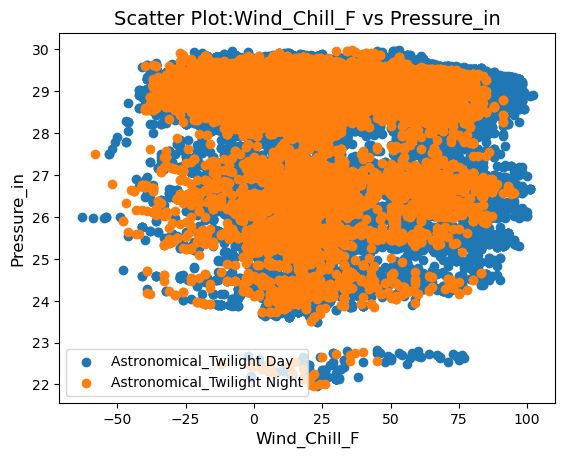

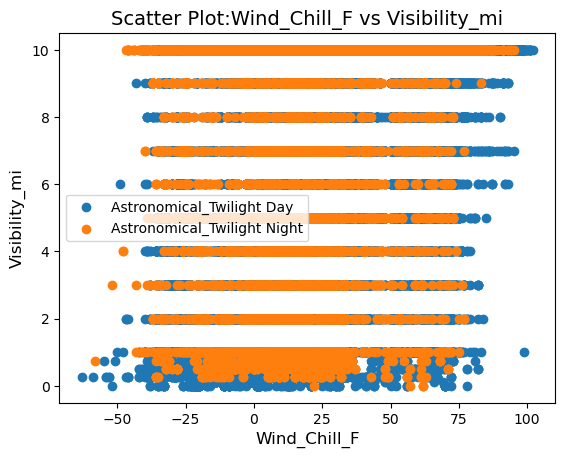

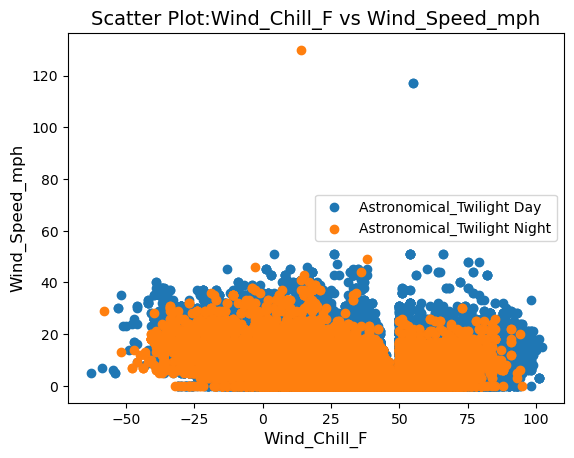

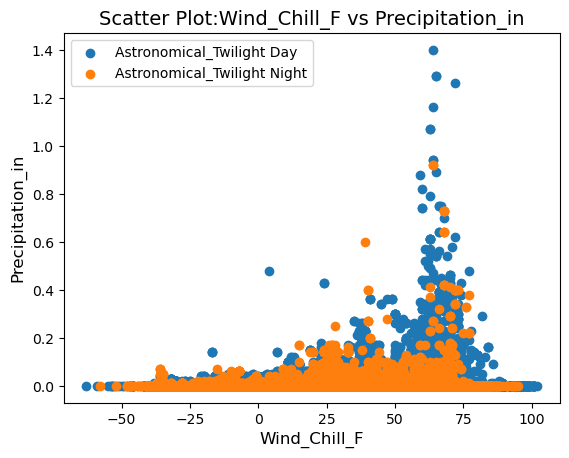

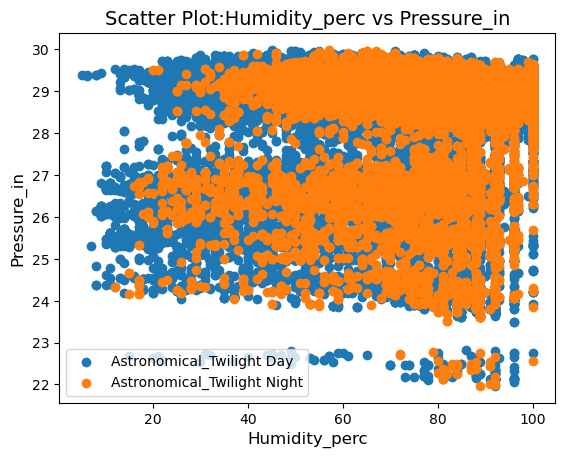

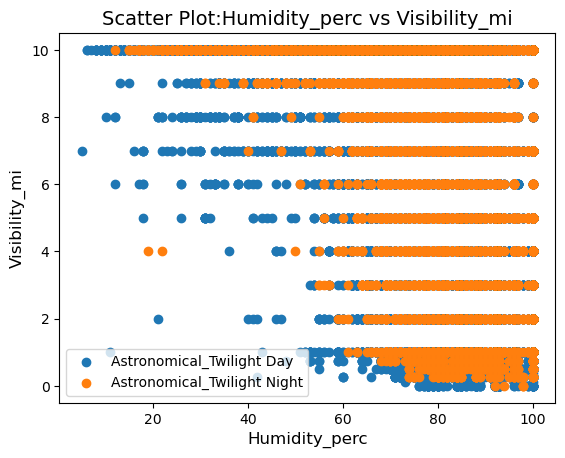

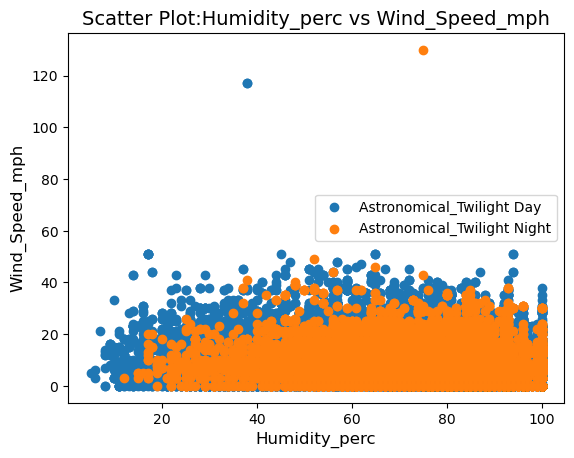

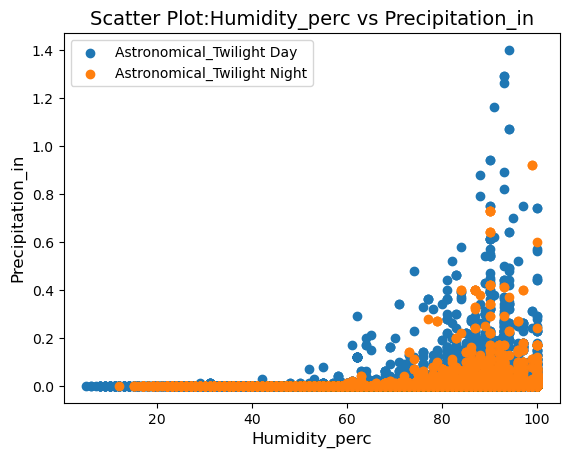

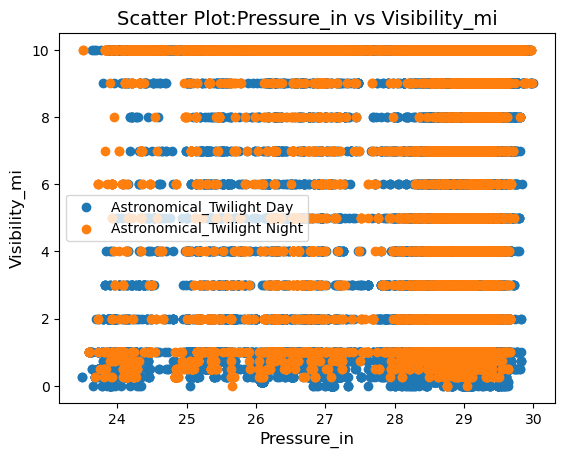

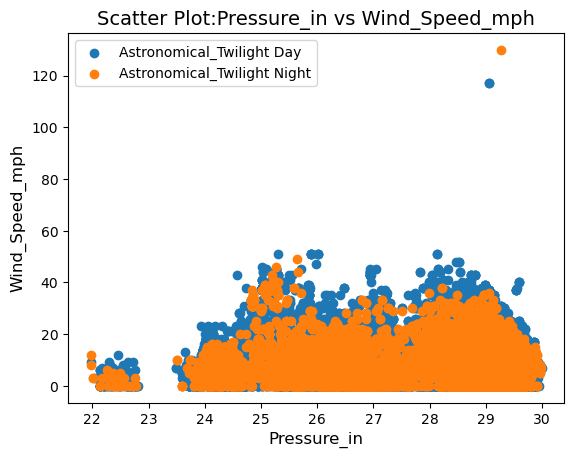

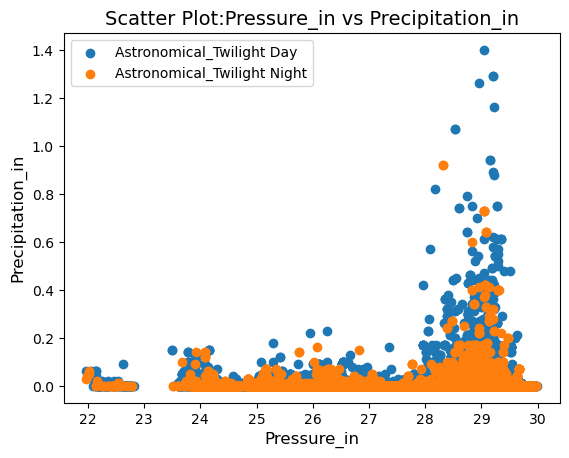

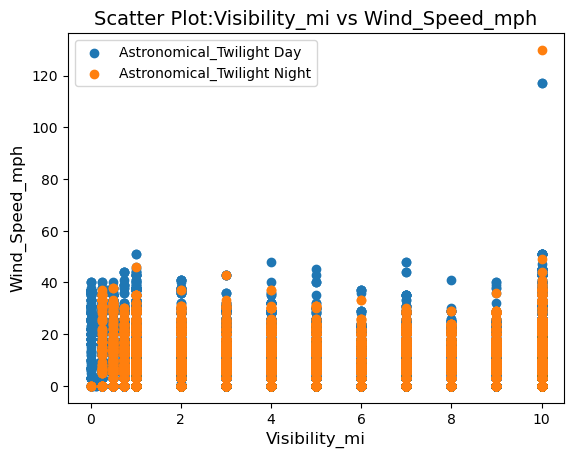

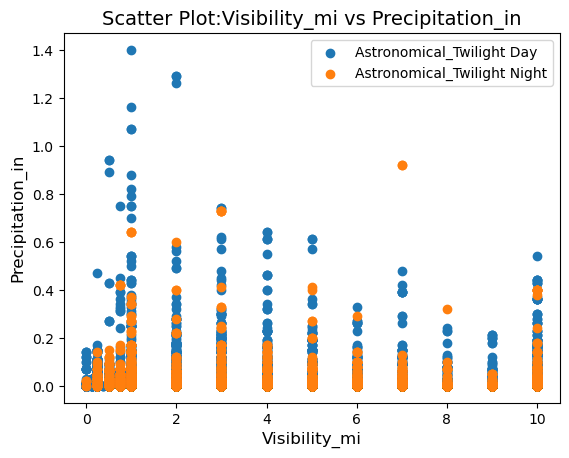

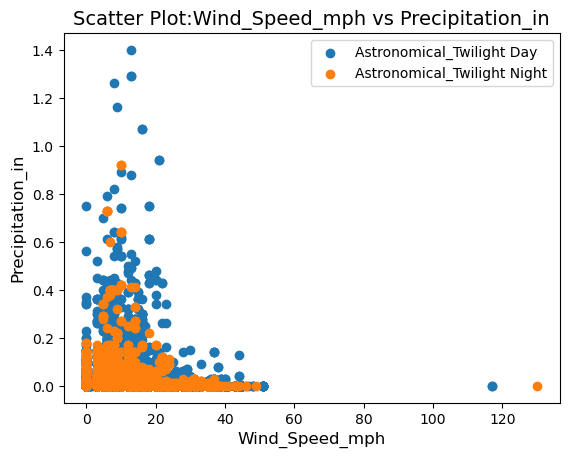

In [27]:
#Scatter con label astronomical_twilight
unique_twilight =['Day','Night']
i=0
for el1 in continuos_features:
    for el2 in continuos_features[i+1:]:
        for twilight_val in unique_twilight:
            data = df.filter(df['Astronomical_Twilight'] == twilight_val).select(el1, el2).dropna().collect()
            x = [row[el1] for row in data]
            y = [row[el2] for row in data]

            plt.scatter(x, y, label=f'Astronomical_Twilight {twilight_val}')

        plt.xlabel(el1, size=12)
        plt.ylabel(el2, size=12)
        plt.title('Scatter Plot:'+el1+ ' vs '+ el2, size=14)
        plt.legend()
        plt.show()
    i+=1

# MISSING VALUES

FILL CITY

In [28]:
#                                               ***** FILLING CITY *****
df.createOrReplaceTempView("missingCity")
query = spark.sql(f'SELECT City,Start_Lat,Start_Lng FROM missingCity m WHERE m.City IS NULL') 
query.show()

+----+-----------------+-----------------+
|City|        Start_Lat|        Start_Lng|
+----+-----------------+-----------------+
|NULL|        45.828716|       -84.726073|
|NULL|43.50095629671336|-95.1747858519784|
|NULL|        43.499488|       -93.353734|
|NULL|        45.836155|       -84.725026|
+----+-----------------+-----------------+



In [29]:
#Checking missing values
from pyspark.sql.functions import when, count, isnull
missing = df.select([count(when(isnull('City'), 'City')).alias('City')])
#missing.toPandas().T
missing.show()

+----+
|City|
+----+
|   4|
+----+



In [30]:
from pyspark.sql.functions import when, lit, col

df = df.withColumn(
    "City",
    when(
        col("City").isNull() & (col("Start_Lat") == 45.828716) & (col("Start_Lng") == -84.726073),
        lit("Sault Sainte Marie")
    ).when(
        col("City").isNull() & (col("Start_Lat") == 43.50095629671336) & (col("Start_Lng") == -95.1747858519784),
        lit("Albert Lea")
    ).when(
        col("City").isNull() & (col("Start_Lat") == 43.499488) & (col("Start_Lng") == -93.353734),
        lit("Albert Lea")
    ).when(
        col("City").isNull() & (col("Start_Lat") == 45.836155) & (col("Start_Lng") == -84.725026),
        lit("Spirit Lake")
    ).otherwise(col("City"))
)


FILL Astronomical_Twilight

In [31]:
from pyspark.sql.functions import month,hour
 
def fill_astronomical_twilight(date, astro): 
    if astro==None:
        month_=date.month
        hour_=date.hour
        if month_>=3 and month_<=5:
            if hour_>=6 and hour_<=19:
                return 'Day'
            else:
                return 'Night'
        elif month_>=6 and month_<=8:
            if hour_>=5 and hour_<=20:
                return 'Day'
            else:
                return 'Night'
        elif month_>=9 and month_<=11:
            if hour_>=5 and hour_<=18:
                return 'Day'
            else:
                return 'Night'
        else:
            if hour_>=7 and hour_<=17:
                return 'Day'
            else:
                return 'Night'
    else:
        return astro

In [32]:
udf_fill_astronomical_twilight = udf(fill_astronomical_twilight, StringType())

In [33]:
df = df.withColumn("Astronomical_Twilight_full", udf_fill_astronomical_twilight(col('Start_Time'),col("Astronomical_Twilight")))

In [34]:
# verifico con una query che la sostituzione sia andata a buon fine 
df.createOrReplaceTempView("missingAss")
query=spark.sql('SELECT Astronomical_Twilight_full, Astronomical_Twilight FROM missingAss m WHERE m.Astronomical_Twilight IS NULL')
query.show()

+--------------------------+---------------------+
|Astronomical_Twilight_full|Astronomical_Twilight|
+--------------------------+---------------------+
|                       Day|                 NULL|
|                       Day|                 NULL|
|                       Day|                 NULL|
|                     Night|                 NULL|
|                       Day|                 NULL|
|                       Day|                 NULL|
|                       Day|                 NULL|
|                       Day|                 NULL|
|                       Day|                 NULL|
|                       Day|                 NULL|
|                       Day|                 NULL|
|                     Night|                 NULL|
|                     Night|                 NULL|
|                       Day|                 NULL|
|                     Night|                 NULL|
|                       Day|                 NULL|
|                       Day|   

In [35]:
from pyspark.sql.functions import when, count, isnull
missing = df.select([count(when(isnull('Astronomical_Twilight_full'), 'Astronomical_Twilight_full')).alias('Astronomical_Twilight_full')])
#missing.toPandas().T
#missing.show()

In [36]:
df=df.drop('Astronomical_Twilight') # elimino la vecchia colonna con in NULL
df=df.withColumnRenamed("Astronomical_Twilight_full", "Astronomical_Twilight") #rinomino la colonna con missing value

Temperature

In [37]:
df=df.withColumn("month", month("Start_Time"))

In [38]:
def season(month_):
    if month_>=3 and month_<=5:
        return 'Spring'
    elif month_>=6 and month_<=8:
        return 'Summer'
    elif month_>=9 and month_<=11:
        return 'Autumn'
    else:
        return 'Winter'

In [39]:
udf_season = udf(season, StringType())

In [40]:
df = df.withColumn("season", udf_season(col('month')))

In [41]:
import pyspark.sql.functions as F
from pyspark.sql import Window

window = Window.partitionBy(["County", "Astronomical_Twilight","season"]).orderBy("County", "Astronomical_Twilight","season")

In [42]:
tmpdf = df.withColumn("avg", F.avg("Temperature_F").over(window))

In [43]:
tmpdf2 = tmpdf.withColumn("Temperature_F", 
                         F.when(F.col("Temperature_F").isNull(),
                                F.col("avg"))
                                .otherwise(F.col("Temperature_F")))

In [44]:
tmpdf3 = tmpdf2.drop("avg")

In [45]:
df= tmpdf3

In [46]:
#Checking missing values
from pyspark.sql.functions import when, count, isnull
missing = df.select([count(when(isnull('Temperature_F'), 'Temperature_F')).alias('Temperature_F')])
#missing.toPandas().T
missing.show()

+-------------+
|Temperature_F|
+-------------+
|           60|
+-------------+



In [47]:
window = Window.partitionBy(["State", "Astronomical_Twilight","season"]).orderBy("State", "Astronomical_Twilight","season")
tmpdf = df.withColumn("avg", F.avg("Temperature_F").over(window))
tmpdf2 = tmpdf.withColumn("Temperature_F", 
                         F.when(F.col("Temperature_F").isNull(),
                                F.col("avg"))
                                .otherwise(F.col("Temperature_F")))
tmpdf3 = tmpdf2.drop("avg")
df = tmpdf3

In [48]:
from pyspark.sql.functions import when, count, isnull
missing = df.select([count(when(isnull('Temperature_F'), 'Temperature_F')).alias('Temperature_F')])
#missing.toPandas().T
missing.show()

+-------------+
|Temperature_F|
+-------------+
|            0|
+-------------+



Fillaggio di Wind_Chill_F

In [49]:
from pyspark.sql.functions import when, count, isnull
missing = df.select([count(when(isnull('Wind_Chill_F'), 'Wind_Chill_F')).alias('Wind_Chill_F')])
#missing.toPandas().T
missing.show()

+------------+
|Wind_Chill_F|
+------------+
|        1585|
+------------+



In [50]:
window = Window.partitionBy(["County", "Astronomical_Twilight","season"]).orderBy("County", "Astronomical_Twilight","season")
tmpdf = df.withColumn("avg", F.avg("Wind_Chill_F").over(window))
tmpdf2 = tmpdf.withColumn("Wind_Chill_F", 
                         F.when(F.col("Wind_Chill_F").isNull(),
                                F.col("avg"))
                                .otherwise(F.col("Wind_Chill_F")))
tmpdf3 = tmpdf2.drop("avg")
df = tmpdf3

In [51]:
# solo righe di controllo 
from pyspark.sql.functions import when, count, isnull
missing = df.select([count(when(isnull('Wind_Chill_F'), 'Wind_Chill_F')).alias('Wind_Chill_F')])
#missing.toPandas().T
missing.show()

+------------+
|Wind_Chill_F|
+------------+
|          75|
+------------+



In [52]:
window = Window.partitionBy(["State", "Astronomical_Twilight","season"]).orderBy("State", "Astronomical_Twilight","season")
tmpdf = df.withColumn("avg", F.avg("Wind_Chill_F").over(window))
tmpdf2 = tmpdf.withColumn("Wind_Chill_F", 
                         F.when(F.col("Wind_Chill_F").isNull(),
                                F.col("avg"))
                                .otherwise(F.col("Wind_Chill_F")))
tmpdf3 = tmpdf2.drop("avg")
df = tmpdf3

In [53]:
missing = df.select([count(when(isnull('Wind_Chill_F'), 'Wind_Chill_F')).alias('Wind_Chill_F')])
#missing.toPandas().T
missing.show()

+------------+
|Wind_Chill_F|
+------------+
|           0|
+------------+



fillaggio Humidity perc

In [54]:
window = Window.partitionBy(["County", "Astronomical_Twilight","season"]).orderBy("County", "Astronomical_Twilight","season")
tmpdf =df.withColumn("avg", F.avg("Humidity_perc").over(window))
tmpdf2 = tmpdf.withColumn("Humidity_perc", 
                         F.when(F.col("Humidity_perc").isNull(),
                                F.col("avg"))
                                .otherwise(F.col("Humidity_perc")))
tmpdf3 = tmpdf2.drop("avg")
df= tmpdf3

In [55]:
missing = df.select([count(when(isnull('Humidity_perc'), 'Humidity_perc')).alias('Humidity_perc')])
#missing.toPandas().T
missing.show()

+-------------+
|Humidity_perc|
+-------------+
|           61|
+-------------+



In [56]:
window = Window.partitionBy(["County","season"]).orderBy("County","season")
tmpdf = df.withColumn("avg", F.avg("Humidity_perc").over(window))
tmpdf2 = tmpdf.withColumn("Humidity_perc", 
                         F.when(F.col("Humidity_perc").isNull(),
                                F.col("avg"))
                                .otherwise(F.col("Humidity_perc")))
tmpdf3 = tmpdf2.drop("avg")
df = tmpdf3

In [57]:
window = Window.partitionBy(["State", "Astronomical_Twilight","season"]).orderBy("County","season")
tmpdf = df.withColumn("avg", F.avg("Humidity_perc").over(window))
tmpdf2 = tmpdf.withColumn("Humidity_perc", 
                         F.when(F.col("Humidity_perc").isNull(),
                                F.col("avg"))
                                .otherwise(F.col("Humidity_perc")))
tmpdf3 = tmpdf2.drop("avg")
df=tmpdf3
#Checking missing values
from pyspark.sql.functions import when, count, isnull
missing = df.select([count(when(isnull("Humidity_perc"), "Humidity_perc")).alias("Humidity_perc")])
missing.toPandas().T

0
Humidity_perc  0

In [58]:
missing = df.select([count(when(isnull('Humidity_perc'),'Humidity_perc')).alias('Humidity_perc')])
#missing.toPandas().T
missing.show()

+-------------+
|Humidity_perc|
+-------------+
|            0|
+-------------+



fillaggio wind direction

In [59]:
missing = df.select([count(when(isnull('Wind_Direction'), 'Wind_Direction')).alias('Wind_Direction')])
#missing.toPandas().T
missing.show()

+--------------+
|Wind_Direction|
+--------------+
|          1515|
+--------------+



In [60]:
window = Window.partitionBy(["County","Wind_Chill_F","season"]).orderBy("County","Wind_Chill_F","season")
tmpdf = df.withColumn("avg", F.avg("Wind_Chill_F").over(window))
tmpdf2 = tmpdf.withColumn("Wind_Chill_F", 
                         F.when(F.col("Wind_Chill_F").isNull(),
                                F.col("avg"))
                                .otherwise(F.col("Wind_Chill_F")))
tmpdf3 = tmpdf2.drop("avg")
df = tmpdf3

In [61]:
missing = df.select([count(when(isnull('Wind_Direction'), 'Wind_Direction')).alias('Wind_Direction')])
#missing.toPandas().T
missing.show()

+--------------+
|Wind_Direction|
+--------------+
|          1515|
+--------------+



In [62]:
window = Window.partitionBy(["State","Wind_Chill_F","season"]).orderBy("County","Wind_Chill_F","season")
tmpdf = df.withColumn("avg", F.avg("Wind_Chill_F").over(window))
tmpdf2 = tmpdf.withColumn("Wind_Direction", 
                         F.when(F.col("Wind_Chill_F").isNull(),
                                F.col("avg"))
                                .otherwise(F.col("Wind_Chill_F")))
tmpdf3 = tmpdf2.drop("avg")
df = tmpdf3

In [63]:
missing = df.select([count(when(isnull('Wind_Direction'), 'Wind_Direction')).alias('Wind_Direction')])
#missing.toPandas().T
missing.show()

+--------------+
|Wind_Direction|
+--------------+
|             0|
+--------------+



fillaggio Wind Speed

In [64]:
missing = df.select([count(when(isnull('Wind_Speed_mph'), 'Wind_Speed_mph')).alias('Wind_Speed_mph')])
#missing.toPandas().T
missing.show()

+--------------+
|Wind_Speed_mph|
+--------------+
|          1513|
+--------------+



In [65]:
window = Window.partitionBy(["County","Wind_Chill_F","season"]).orderBy("County","Wind_Chill_F","season")
tmpdf = df.withColumn("avg", F.avg("Wind_Speed_mph").over(window))
tmpdf2 = tmpdf.withColumn("Wind_Speed_mph", 
                         F.when(F.col("Wind_Speed_mph").isNull(),
                                F.col("avg"))
                                .otherwise(F.col("Wind_Speed_mph")))
tmpdf3 = tmpdf2.drop("avg")
df = tmpdf3

In [66]:
missing = df.select([count(when(isnull('Wind_Speed_mph'), 'Wind_Speed_mph')).alias('Wind_Speed_mph')])
#missing.toPandas().T
missing.show()

+--------------+
|Wind_Speed_mph|
+--------------+
|          1325|
+--------------+



In [67]:
window = Window.partitionBy(["State","Wind_Chill_F","season"]).orderBy("State","Wind_Chill_F","season")
tmpdf = df.withColumn("avg", F.avg("Wind_Speed_mph").over(window))
tmpdf2 = tmpdf.withColumn("Wind_Speed_mph", 
                         F.when(F.col("Wind_Speed_mph").isNull(),
                                F.col("avg"))
                                .otherwise(F.col("Wind_Speed_mph")))
tmpdf3 = tmpdf2.drop("avg")
df = tmpdf3

In [68]:
missing = df.select([count(when(isnull('Wind_Speed_mph'), 'Wind_Speed_mph')).alias('Wind_Speed_mph')])
#missing.toPandas().T
missing.show()

+--------------+
|Wind_Speed_mph|
+--------------+
|          1302|
+--------------+



In [69]:
window = Window.partitionBy(["County","season"]).orderBy("County","season")
tmpdf = df.withColumn("avg", F.avg("Wind_Speed_mph").over(window))
tmpdf2 = tmpdf.withColumn("Wind_Speed_mph", 
                         F.when(F.col("Wind_Speed_mph").isNull(),
                                F.col("avg"))
                                .otherwise(F.col("Wind_Speed_mph")))
tmpdf3 = tmpdf2.drop("avg")
df = tmpdf3

In [70]:
window = Window.partitionBy(["State","season"]).orderBy("State", "Wind_Chill_F","season")
tmpdf = df.withColumn("avg", F.mode("Wind_Speed_mph").over(window))
tmpdf2 = tmpdf.withColumn("Wind_Speed_mph", 
                         F.when(F.col("Wind_Speed_mph").isNull(),
                                F.col("avg"))
                                .otherwise(F.col("Wind_Speed_mph")))
tmpdf3 = tmpdf2.drop("avg")
df=tmpdf3
#Checking missing values
from pyspark.sql.functions import when, count, isnull
missing = df.select([count(when(isnull("Wind_Speed_mph"), "Wind_Speed_mph")).alias("Wind_Speed_mph")])
missing.toPandas().T

0
Wind_Speed_mph  0

In [71]:
missing = df.select([count(when(isnull('Wind_Speed_mph'), 'Wind_Speed_mph')).alias('Wind_Speed_mph')])
#missing.toPandas().T
missing.show()

+--------------+
|Wind_Speed_mph|
+--------------+
|             0|
+--------------+



fillaggio Precipitation

In [72]:
missing = df.select([count(when(isnull('Precipitation_in'), 'Precipitation_in')).alias('Precipitation_in')])
#missing.toPandas().T
missing.show()
#numero originario 

+----------------+
|Precipitation_in|
+----------------+
|             955|
+----------------+



In [73]:
window = Window.partitionBy(["City","month"]).orderBy("City","month")
tmpdf = df.withColumn("mode", F.mode("Precipitation_in").over(window)) # qui abbiamo usato la MODE
tmpdf2 = tmpdf.withColumn("Precipitation_in", 
                         F.when(F.col("Precipitation_in").isNull(),
                                F.col("mode"))
                                .otherwise(F.col("Precipitation_in")))
tmpdf3 = tmpdf2.drop("mode")
df = tmpdf3

In [74]:
missing = df.select([count(when(isnull('Precipitation_in'), 'Precipitation_in')).alias('Precipitation_in')])
#missing.toPandas().T
missing.show()

+----------------+
|Precipitation_in|
+----------------+
|             467|
+----------------+



In [75]:
window = Window.partitionBy(["County","month"]).orderBy("County","month")
tmpdf = df.withColumn("mode", F.mode("Precipitation_in").over(window))
tmpdf2 = tmpdf.withColumn("Precipitation_in", 
                         F.when(F.col("Precipitation_in").isNull(),
                                F.col("mode"))
                                .otherwise(F.col("Precipitation_in")))
tmpdf3 = tmpdf2.drop("mode")
df = tmpdf3

In [76]:
window = Window.partitionBy(["State","season"]).orderBy("County", "month")
tmpdf = df.withColumn("mode", F.mode("Precipitation_in").over(window))
tmpdf2 = tmpdf.withColumn("Precipitation_in", 
                         F.when(F.col("Precipitation_in").isNull(),
                                F.col("mode"))
                                .otherwise(F.col("Precipitation_in")))
tmpdf3 = tmpdf2.drop("mode")
df=tmpdf3
#Checking missing values
from pyspark.sql.functions import when, count, isnull
missing = df.select([count(when(isnull("Precipitation_in"), "Precipitation_in")).alias("Precipitation_in")])
missing.toPandas().T

0
Precipitation_in  0

In [77]:
missing = df.select([count(when(isnull('Precipitation_in'), 'Precipitation_in')).alias('Precipitation_in')])
#missing.toPandas().T
missing.show()

+----------------+
|Precipitation_in|
+----------------+
|               0|
+----------------+



Weather_Condition

In [78]:

def update_weather_values(df):
    df_new = df.withColumn(
        "Weather_Condition",
        when(
            col("Weather_Condition").isin("Fair", "Fair / Windy", "Thunder in the Vicinity", "Showers in the Vicinity"),
            "Normal"
        ).when(
            col("Weather_Condition").isin(
                "Fog", "Smoke", "Smoke / Windy", "Haze", "Shallow Fog",
                "Patches of Fog", "Haze / Windy", "Fog / Windy", "Mist",
                "Widespread Dust", "Widespread Dust / Windy", "Blowing Dust / Windy",
                "Blowing Dust", "Drizzle and Fog", "Shallow Fog / Windy"
            ),
            "Foggy"
        ).when(
            col("Weather_Condition").isin(
                "Cloudy", "Cloudy / Windy", "Partly Cloudy", "Mostly Cloudy",
                "Partly Cloudy / Windy", "Mostly Cloudy / Windy"
            ),
            "Cloudy"
        ).when(
            col("Weather_Condition").isin(
                "Wintry Mix", "Sleet", "Light Snow / Windy", "Snow", "Heavy Snow with Thunder",
                "Light Snow", "Heavy Snow", "Light Freezing Rain", "Light Snow Shower", "Light Snow Shower / Windy",
                "Heavy Snow / Windy", "Snow / Windy", "Small Hail", "Light Snow and Sleet / Windy",
                "Blowing Snow / Windy", "Light Sleet / Windy", "Snow and Thunder",
                "Hail", "Wintry Mix / Windy", "Light Snow with Thunder", "Snow and Sleet / Windy", "Heavy Sleet",
                "Thunder and Hail", "Light Sleet", "Light Snow and Sleet", "Snow and Sleet", "Blowing Snow", "Drifting Snow / Windy"
            ),
            "Snow"
        ).when(
            col("Weather_Condition").isin(
                "Rain", "Light Drizzle", "Light Rain with Thunder", "T-Storm", "Tornado",
                "Drizzle", "Heavy Rain", "Thunder", "Light Rain",
                "Light Rain / Windy", "Rain / Windy", "Heavy Rain / Windy",
                "Heavy T-Storm", "Rain Shower", "Squalls", "Heavy T-Storm / Windy",
                "Heavy Drizzle", "Light Rain Shower", "Light Drizzle / Windy",
                "Light Freezing Rain / Windy", "Drizzle / Windy", "Thunder / Windy",
                "T-Storm / Windy", "N/A Precipitation", "Light Freezing Drizzle", "Freezing Rain", "Freezing Rain / Windy", "Squalls / Windy"
            ),
            "Rain"
        ).otherwise(col("Weather_Condition"))
    )


    return df_new

In [79]:
df=update_weather_values(df)

In [80]:
def fill_Weather_Condition(precipitation,temperature, weather): 
    if weather is None:
        if precipitation>0 and temperature>32:
            return 'Rain'
        elif precipitation>0 and temperature<=32:
            return 'Snow'
        else:
            return weather
    else: 
        return weather

In [81]:
udf_fill_Weather_Condition = udf(fill_Weather_Condition, StringType())

In [82]:
df = df.withColumn("Weather_Condition_full", fill_Weather_Condition(col('Precipitation_in'),col('Temperature_F'),col("Weather_Condition")))

In [83]:
df=df.drop('Weather_Condition') # elimino la vecchia colonna con in NULL
df=df.withColumnRenamed("Weather_Condition_full", "Weather_Condition") #rinomino la colonna con missing value

In [84]:
#Checking missing value
from pyspark.sql.functions import when, count, isnull
missing = df.select([count(when(isnull("Weather_Condition"), "Weather_Condition")).alias("Weather_Condition")])
missing.show()

+-----------------+
|Weather_Condition|
+-----------------+
|             1360|
+-----------------+



In [85]:
import pyspark.sql.functions as F
from pyspark.sql import Window

window = Window.partitionBy(["City","month"]).orderBy("City", "month")
tmpdf = df.withColumn("mode", F.mode("Weather_Condition").over(window))
tmpdf2 = tmpdf.withColumn("Weather_Condition", 
                         F.when(F.col("Weather_Condition").isNull(),
                                F.col("mode"))
                                .otherwise(F.col("Weather_Condition")))
tmpdf3 = tmpdf2.drop("mode")
df=tmpdf3

In [86]:
#Checking missing value
missing = df.select([count(when(isnull("Weather_Condition"), "Weather_Condition")).alias("Weather_Condition")])
missing.show()

+-----------------+
|Weather_Condition|
+-----------------+
|              688|
+-----------------+



In [87]:
window = Window.partitionBy(["County","month"]).orderBy("County", "month")
tmpdf = df.withColumn("mode", F.mode("Weather_Condition").over(window))
tmpdf2 = tmpdf.withColumn("Weather_Condition", 
                         F.when(F.col("Weather_Condition").isNull(),
                                F.col("mode"))
                                .otherwise(F.col("Weather_Condition")))
tmpdf3 = tmpdf2.drop("mode")
df=tmpdf3

In [88]:
#Checking missing value
missing = df.select([count(when(isnull("Weather_Condition"), "Weather_Condition")).alias("Weather_Condition")])
missing.show()

+-----------------+
|Weather_Condition|
+-----------------+
|               81|
+-----------------+



In [89]:
window = Window.partitionBy(["State","month"]).orderBy("State", "month")
tmpdf = df.withColumn("mode", F.mode("Weather_Condition").over(window))
tmpdf2 = tmpdf.withColumn("Weather_Condition", 
                         F.when(F.col("Weather_Condition").isNull(),
                                F.col("mode"))
                                .otherwise(F.col("Weather_Condition")))
tmpdf3 = tmpdf2.drop("mode")
df=tmpdf3

In [90]:
#Checking missing value
missing = df.select([count(when(isnull("Weather_Condition"), "Weather_Condition")).alias("Weather_Condition")])
missing.show()

+-----------------+
|Weather_Condition|
+-----------------+
|                0|
+-----------------+



Visibility_mi

In [91]:
Window = Window.partitionBy(["County","Weather_Condition","Astronomical_Twilight"]).orderBy("County","Weather_Condition", "Astronomical_Twilight")
tmpdf = df.withColumn("mode", F.mode("Visibility_mi").over(window))
tmpdf2 = tmpdf.withColumn("Visibility_mi", 
                         F.when(F.col("Visibility_mi").isNull(),
                                F.col("mode"))
                                .otherwise(F.col("Visibility_mi")))
tmpdf3 = tmpdf2.drop("mode")
df=tmpdf3

In [92]:
#Checking missing value
missing = df.select([count(when(isnull("Visibility_mi"), "Visibility_mi")).alias("Visibility_mi")])
missing.show()

+-------------+
|Visibility_mi|
+-------------+
|            0|
+-------------+



Droppo 'Pressure_in'

In [93]:
df = df.drop("Pressure_in")

In [94]:
missing = df.select([count(when(isnull(c), c)).alias(c) for c in df.columns])
missing.toPandas().T
missing.show()

+--------+----------+---------+---------+-----------+----+------+-----+-------------+------------+-------------+-------------+--------------+--------------+----------------+-------+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+-----+---------------+----+------+---------------+---------------------+-----------------+
|Severity|Start_Time|Start_Lat|Start_Lng|Distance_mi|City|County|State|Temperature_F|Wind_Chill_F|Humidity_perc|Visibility_mi|Wind_Direction|Wind_Speed_mph|Precipitation_in|Amenity|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station|Stop|Traffic_Calming|Traffic_Signal|month|day_of_the_week|hour|season|Working_Weekend|Astronomical_Twilight|Weather_Condition|
+--------+----------+---------+---------+-----------+----+------+-----+-------------+------------+-------------+-------------+--------------+--------------+----------------+-------+--------+--------+--------+-------+-------+----------+-------+----+------------

Remove Duplicates

In [95]:
rows = df.count()
cols = len(df.columns)
print(f'Il Dataset contiene {rows} records con duplicati')
print('\n')
df = df.distinct()
rows2 = df.count()
print(f'Il Dataset contiene {rows2} record distinti')

Il Dataset contiene 90767 records con duplicati




Il Dataset contiene 83267 record distinti
